# 0. Libs & Initialization

In [1]:
!pip install pandasql -q
!pip install catboost -q
!pip install shap -q
!pip install xgboost -q
!pip install openpyxl -q
# !pip install lightgbm -q

In [2]:
import pickle
import calendar
import gc
import random
from datetime import date, timedelta, datetime
import openpyxl

from tqdm.auto import tqdm

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

import seaborn as sns
sns.set_palette('muted') # for the sns palette
sns.set_color_codes('muted')
sns.set_style('white') # grid

import matplotlib.pyplot as plt
# pd.options.plotting.backend = "plotly"

import warnings
warnings.filterwarnings('ignore')

import scipy.stats
from statsmodels.graphics.mosaicplot import mosaic
from pandasql import sqldf

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ParameterGrid

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import ElasticNet

from sklearn.impute import SimpleImputer

from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder

from sklearn.pipeline import make_pipeline, Pipeline

from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report
from sklearn.metrics import precision_score, average_precision_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, precision_recall_curve, RocCurveDisplay 
from sklearn.metrics import roc_curve, auc, f1_score

import shap

from catboost import CatBoostClassifier
from catboost import Pool

import xgboost as xgb
# import lightgbm as lgb

In [4]:
home_repo = '/home/jovyan'
project_repo = f'{home_repo}/__RAYDTT'

%cd {project_repo}
%pwd

/home/jovyan/__RAYDTT


'/home/jovyan/__RAYDTT'

In [5]:
SEED = 42
model_name = 'CatBoostClassifier'
trials_path = '/pickles/{}_optuna_trials.pickle'.format(model_name)

In [40]:
def plot_roc_curve(y_true, y_pred_proba):

    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    roc_auc = roc_auc_score(y_true, y_pred_proba)

    # Plot the ROC curve
    plt.figure(figsize=(17, 10))
    plt.plot(fpr, tpr, color=color[0] , lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color=color[1], lw=2, linestyle='--') # ['#74197f','#14b956']
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()

    return roc_auc

In [10]:
def get_reports(y_pred, y_true, perc=[0.01, 0.03, 0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.]):

    y_pred = pd.Series(y_pred)
    y_true = pd.Series(y_true)
    print('ROC AUC: %.3f' % roc_auc_score(y_true, y_pred))

    coef = y_true.sum() / len(y_true)

    report = pd.DataFrame(columns=[], index=['LIFT', 'PRECISION', 'RECALL', 'COUNT'])   

    for p in perc:

        thr = y_pred.quantile(1-p)

        report['top {}%'.format(int(p*100))] = pd.Series([

            np.round(precision_score(y_true, np.round(y_pred-thr+0.5)) / coef, 3),

            np.round(precision_score(y_true, np.round(y_pred-thr+0.5)), 3),

            np.round(recall_score(y_true, np.round(y_pred-thr+0.5)), 3),

            np.round(y_pred-thr+0.5).sum()

        ], index=report.index)
    
    return report

In [11]:
def build_subsample(
        X_test: object,
        target_name: str, 
        target_class: int, 
        target_class_decrease: bool,
        share: float,
        random_seed: list

    ) -> np.array:
        
        # таргет
        y_true = X_test.loc[:, target_name]
        # отделил целевой класс от нецелевого
        y_true_target_class = y_true[y_true==target_class]
        y_true_non_target_class = y_true[y_true!=target_class]

        if target_class_decrease:
            # уменьшаем целевой класс: в числителе пропорция по нахождению меньшего, чем фактическое, значения целевого класса
            # при условии, что нецелевой класс берется полностью
            decrease_share = ((len(y_true_non_target_class)*share) / (1-share)) / len(y_true_target_class)
            # ловит случай, когда доля текущего целевого класса = 0%
            if decrease_share==0:
                return np.array([None])
            # ловит случай, когда доля текущего целевого класса > 100%
            # (например, на трейне был имбаланс по целевому классу, на тесте - по нецелевому)
            elif decrease_share>1:
                decrease_share=1
            y_true_target_class_sliced = y_true_target_class.sample(frac = decrease_share, random_state = random_seed)
            y_true_new = pd.concat([y_true_target_class_sliced, y_true_non_target_class], axis=0)

        else:
            # увеличиваем целевой класс: в числителе пропорция по нахождению меньшего, чем фактическое, значения нецелевого класса
            # при условии, что целевой класс берется полностью
            decrease_share = ((len(y_true_target_class)*(1-share)) / share) / len(y_true_non_target_class)
            # для случае, когда берется та же доля целевого и нецелевого классов, что и была
            # ловит случай, когда доля текущего целевого класса = 0%
            if decrease_share==0:
                return np.array([None])
            # ловит случай, когда доля текущего целевого класса > 100%
            # (например, на трейне был имбаланс по целевому классу, на тесте - по нецелевому)
            if decrease_share>1:
                decrease_share=1
            y_true_non_target_class_sliced = y_true_non_target_class.sample(frac = decrease_share, random_state = random_seed)
            y_true_new = pd.concat([y_true_target_class, y_true_non_target_class_sliced], axis=0)
            
        idx2shuffle = y_true_new.index.to_numpy()
        random.seed(random_seed)
        # перемешал новый таргет для чистоты эксперимента
        idx_shuffled = random.sample(sorted(idx2shuffle), len(idx2shuffle))
        return X_test.loc[idx_shuffled]

def process_by_split(
        split_train, # df
        split_test,  # df
        target_class: int,
        target_name, # target name     
        avg_proba_thershold: float,
        num_of_samples: int,
        random_seed: int = 42
) -> np.ndarray:

    # посмотрел долю целевого класса на трейне
    y_fact_train = split_train[target_name]
    y_fact_test = split_test[target_name]
    avg_fact_proba_train = np.sum([int(i == target_class) for i in y_fact_train]) / len(y_fact_train)
    avg_fact_proba_test = np.sum([int(i == target_class) for i in y_fact_test]) / len(y_fact_test)

    # недоминирующий целевой класс на трейне предполагает увеличение доли доминирующего целевого на тесте
    if avg_fact_proba_train < avg_proba_thershold:
        # на трейне доминирует нецелевой класс, как и на тесте
        if avg_fact_proba_test < avg_proba_thershold:
            avg_proba_space_for_test = np.linspace(avg_proba_thershold, 1, num_of_samples, dtype=float)
        # на трейне доминирует нецелевой класс, на тесте доминирует целевой класс
        # по сути, это нам и надо для тестирования, поэтому будем итерироваться по долям класса от avg_proba_space_for_test до 1
        else:
            avg_proba_space_for_test = np.linspace(avg_fact_proba_test, 1, num_of_samples, dtype=float)
        target_class_decrease = False
    # доминирующий целевой класс на трейне предполагает снижение его доли на тесте
    elif avg_fact_proba_train >= avg_proba_thershold:
        # на трейне доминирует целевой класс, на тесте доминирует нецелевой класс
        # это нам и надо для тестирования, поэтому будем итерироваться по долям класса от 0 до avg_proba_space_for_test
        if avg_fact_proba_test < avg_proba_thershold:
            avg_proba_space_for_test = np.linspace(0, avg_fact_proba_test, num_of_samples, dtype=float)
        # на трейне доминирует целевой класс, как и на тесте
        else:
            avg_proba_space_for_test = np.linspace(0, avg_proba_thershold, num_of_samples, dtype=float)
        # повышаем долю целевого класса в соответствии с переданным числом раз
        target_class_decrease = True

    return np.vectorize(lambda share: build_subsample(
        split_test, 
        target_name, 
        target_class,
        target_class_decrease, 
        share, 
        random_seed
        ), otypes=[np.ndarray])\
        (avg_proba_space_for_test)

-----

In [6]:
train = pd.read_parquet('bs_segments_new/train_upd.parquet')
train = train[train.target_month != '2022-05-01']

test = pd.read_parquet('bs_segments_new/test_upd.parquet')

all_dataset = pd.concat([train, test], ignore_index=True)

In [7]:
target_months = all_dataset.target_month.unique().tolist()
target_months.sort()

train_months = target_months[:14]
test_months = target_months[14:16]

len(train_months), len(test_months)

(14, 2)

In [8]:
train = all_dataset[all_dataset.target_month.isin(train_months)]
test = all_dataset[all_dataset.target_month.isin(test_months)]

In [11]:
train.shape, test.shape,\
train.target.mean(), test.target.mean()

((414989, 593), (147517, 593), 0.012019595700126992, 0.010392022614342755)

In [12]:
ratio_of_ones_in_train_sampled = 0.3
ratio_of_ones_in_test_sampled = 0.05 # wtf

test_part = 0.2
train_part = 1 - test_part
test_to_train = test_part / train_part

train_part, test_part, test_to_train, ratio_of_ones_in_train_sampled, ratio_of_ones_in_test_sampled

(0.8, 0.2, 0.25, 0.3, 0.05)

In [13]:
train_sampled_count_1 = (train['target'] == 1).sum()
train_sampled_count = train_sampled_count_1 / ratio_of_ones_in_train_sampled
train_sampled_count_0 = train_sampled_count - train_sampled_count_1
train_fraction_0 = train_sampled_count_0 / (train['target'] == 0).sum()
train_fraction_1 = 1 
train_fraction_0, train_fraction_1

(0.028386922633522035, 1)

In [14]:
train_sampled = pd.concat([
    train[train['target'] == 0].sample(frac=train_fraction_0, random_state=SEED),
    train[train['target'] == 1]
])

In [15]:
test_sampled_count = len(train_sampled) * test_to_train
test_sampled_count_1 = test_sampled_count * ratio_of_ones_in_test_sampled
test_sampled_count_0 = test_sampled_count * (1 - ratio_of_ones_in_test_sampled)

test_fraction_0 = test_sampled_count_0 / (test['target'] == 0).sum()
test_fraction_1 = test_sampled_count_1 / (test['target'] == 1).sum()
test_fraction_0, test_fraction_1

(0.027050310307978956, 0.13557566862361384)

In [16]:
test_sampled = pd.concat([
    test[test['target'] == 0].sample(frac=min(test_fraction_0, 1), random_state=SEED),
    test[test['target'] == 1].sample(frac=min(test_fraction_1, 1), random_state=SEED)
])

In [17]:
train_sampled.target.mean(), test_sampled.target.mean(),\
train_sampled.shape, test_sampled.shape

(0.2999939856859325, 0.050036083714216986, (16627, 593), (4157, 593))

In [18]:
train = train_sampled
test = test_sampled

# 1. EDA

## Train-Test barplot

In [12]:
color_0 = ['#d53e4f', '#fc8d59', '#fee08b', '#e6f598', '#99d594', '#3288bd']
color_1 = ['#74197f','#14b956']
color = ['#3288bd', '#99d594']
color = color + color_0 + color_1

In [47]:
agg_all_dataset_1 = all_dataset[all_dataset.target == 1].groupby('target_month')['target'].count().to_frame().reset_index()
agg_all_dataset_0 = all_dataset[all_dataset.target == 0].groupby('target_month')['target'].count().to_frame().reset_index()
agg_all_dataset = agg_all_dataset_1.merge(agg_all_dataset_0, on = 'target_month', how = 'left') \
    .rename(columns={'target_x': 'target_1', 'target_y': 'target_0'})
agg_all_dataset['target_month'] = agg_all_dataset['target_month'].str.slice(0, 10)

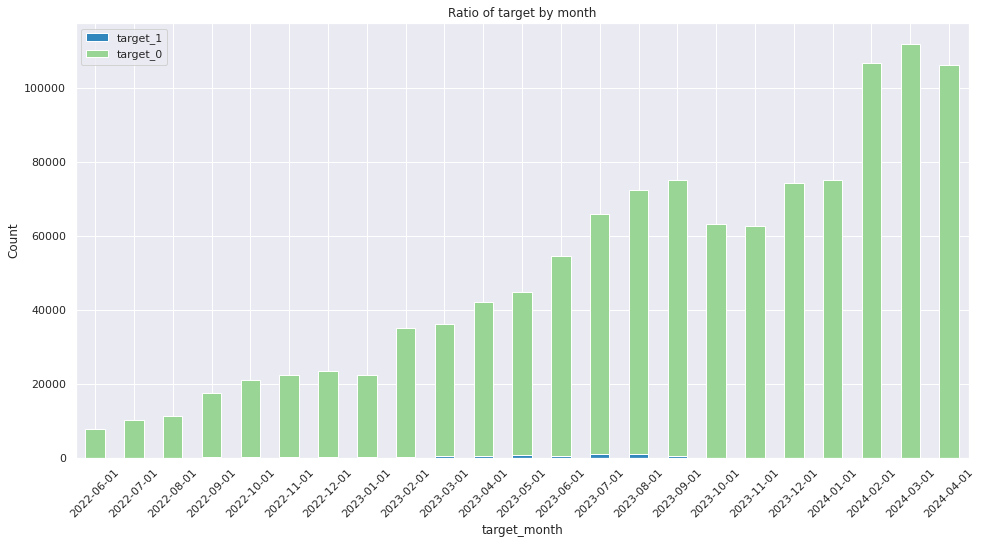

In [50]:
sns.set(rc = {'figure.figsize':(16, 8)})
agg_all_dataset.groupby('target_month').sum().plot(kind='bar', stacked=True, 
                        color = color)
plt.ylabel("Count")
plt.title("Ratio of target by month")
plt.xticks(rotation=45)
plt.show()

In [ ]:
# agg_train_1 = train[train.target == 1].groupby('target_month')['target'].count().to_frame().reset_index()
# agg_train_0 = train[train.target == 0].groupby('target_month')['target'].count().to_frame().reset_index()
# agg_train = agg_train_1.merge(agg_train_0, on = 'target_month', how = 'left') \
#     .rename(columns={'target_x': 'target_1', 'target_y': 'target_0'})
# agg_train['target_month'] = agg_train['target_month'].str.slice(0, 10)

In [ ]:
# sns.set(rc = {'figure.figsize':(16, 8)})
# agg_train.groupby('target_month').sum().plot(kind='bar', stacked=True, 
#                         color = color)
# plt.ylabel("Count")
# plt.title("Доля целевого события по дате скоринга")
# plt.xticks(rotation=45)
# plt.show()

In [ ]:
# agg_test_1 = test[test.target == 1].groupby('target_month')['target'].count().to_frame().reset_index()
# agg_test_0 = test[test.target == 0].groupby('target_month')['target'].count().to_frame().reset_index()
# agg_test = agg_test_1.merge(agg_test_0, on = 'target_month', how = 'left') \
#     .rename(columns={'target_x': 'target_1', 'target_y': 'target_0'})
# agg_test['target_month'] = agg_test['target_month'].str.slice(0, 10)

In [ ]:
# sns.set(rc = {'figure.figsize':(16, 8)})
# agg_test.groupby('target_month').sum().plot(kind='bar', stacked=True, color = color)
# plt.ylabel("Count")
# plt.title("Доля целевого события по дате скоринга")
# plt.xticks(rotation=45)
# plt.show()

In [ ]:
# pysqldf = lambda q: sqldf(q, globals())
# query = '''
# SELECT
#     amplitude_id
#     ,target_month
#     ,target
# FROM train
# WHERE amplitude_id IN(SELECT amplitude_id FROM train GROUP BY amplitude_id HAVING COUNT(*) > 1)
# ORDER BY amplitude_id, target_month
# '''
# result_df = pysqldf(query)

In [52]:
filtered_ids = all_dataset[all_dataset.target == 1]['amplitude_id'].value_counts().index
#filtered_ids = filtered_ids[filtered_ids > 1].index
filtered_all_dataset = all_dataset[all_dataset['amplitude_id'].isin(filtered_ids)]
sorted_all_dataset = filtered_all_dataset.sort_values(by=['amplitude_id', 'target_month'])

In [ ]:
# sorted_all_dataset[['amplitude_id', 'target_month', 'target', 'target_date', 'target_date_timestamp']].head(100)

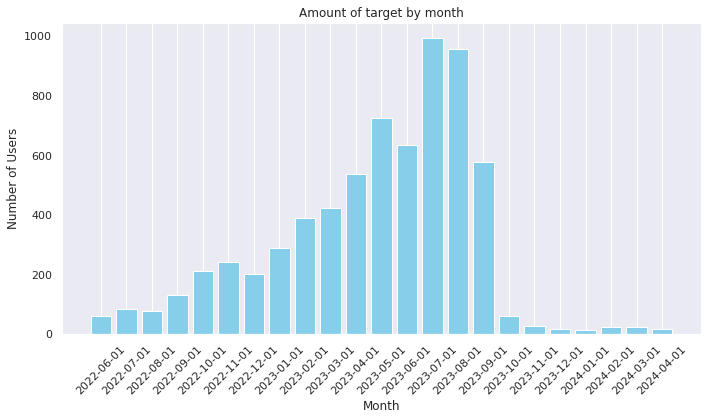

In [54]:
monthly_targets = sorted_all_dataset.groupby('target_month')['target'].sum().reset_index()

plt.figure(figsize=(10, 6))
plt.bar(monthly_targets['target_month'], monthly_targets['target'], color='skyblue')
plt.title('Amount of target by month')
plt.xlabel('Month')
plt.ylabel('Number of Users')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [55]:
all_dataset.groupby('target_month')['target'].sum()

target_month
2022-06-01     61
2022-07-01     84
2022-08-01     76
2022-09-01    130
2022-10-01    212
2022-11-01    240
2022-12-01    200
2023-01-01    288
2023-02-01    388
2023-03-01    421
2023-04-01    536
2023-05-01    724
2023-06-01    634
2023-07-01    994
2023-08-01    955
2023-09-01    578
2023-10-01     61
2023-11-01     27
2023-12-01     18
2024-01-01     14
2024-02-01     24
2024-03-01     23
2024-04-01     16
Name: target, dtype: int32

In [58]:
(all_dataset.groupby('target_month')['target'].mean()*100).round(3)

target_month
2022-06-01    0.780
2022-07-01    0.821
2022-08-01    0.664
2022-09-01    0.742
2022-10-01    1.001
2022-11-01    1.070
2022-12-01    0.854
2023-01-01    1.290
2023-02-01    1.107
2023-03-01    1.166
2023-04-01    1.273
2023-05-01    1.614
2023-06-01    1.162
2023-07-01    1.508
2023-08-01    1.319
2023-09-01    0.769
2023-10-01    0.096
2023-11-01    0.043
2023-12-01    0.024
2024-01-01    0.019
2024-02-01    0.022
2024-03-01    0.021
2024-04-01    0.015
Name: target, dtype: float64

In [13]:
all_dataset.columns.to_list()

['amplitude_id',
 'target_month',
 'explain_errors_sum_5',
 'explain_errors_avg_5',
 'explain_errors_min_5',
 'explain_errors_max_5',
 'explain_errors_std_5',
 'favorites_count_sum_5',
 'favorites_count_avg_5',
 'favorites_count_min_5',
 'favorites_count_max_5',
 'favorites_count_std_5',
 'hazard_progress_sum_5',
 'hazard_progress_avg_5',
 'hazard_progress_min_5',
 'hazard_progress_max_5',
 'hazard_progress_std_5',
 'hazard_solved_sum_5',
 'hazard_solved_avg_5',
 'hazard_solved_min_5',
 'hazard_solved_max_5',
 'hazard_solved_std_5',
 'percent_solved_sum_5',
 'percent_solved_avg_5',
 'percent_solved_min_5',
 'percent_solved_max_5',
 'percent_solved_std_5',
 'right_answers_sum_5',
 'right_answers_avg_5',
 'right_answers_min_5',
 'right_answers_max_5',
 'right_answers_std_5',
 'wrong_answers_sum_5',
 'wrong_answers_avg_5',
 'wrong_answers_min_5',
 'wrong_answers_max_5',
 'wrong_answers_std_5',
 'cohort_day_sum_5',
 'cohort_day_avg_5',
 'cohort_day_min_5',
 'cohort_day_max_5',
 'cohort_day

In [14]:
region = all_dataset.groupby('region_mode_60')['target'].sum().reset_index()\
    .sort_values(by=['target'], ascending = False).head(10)

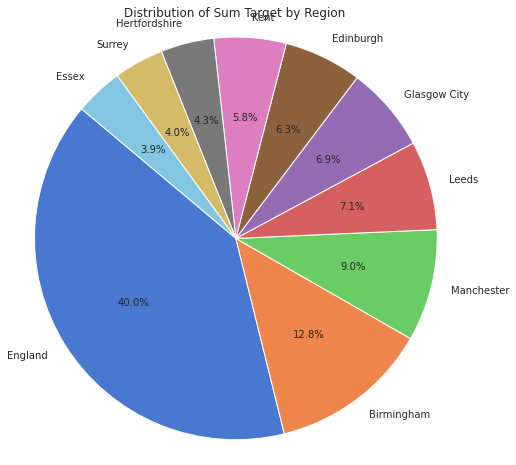

In [15]:
plt.figure(figsize=(8, 8))  # Set the figure size
plt.pie(region['target'], labels=region['region_mode_60'], autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Sum Target by Region')  # Add a title
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [16]:
region = all_dataset.groupby('country_mode_60')['target'].sum().reset_index()\
    .sort_values(by=['target'], ascending = False).head(10)

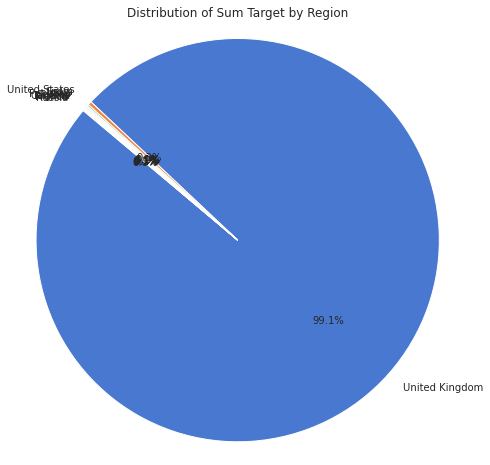

In [18]:
plt.figure(figsize=(8, 8))  # Set the figure size
plt.pie(region['target'], labels=region['country_mode_60'], autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Sum Target by Region')  # Add a title
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [57]:
target_by_target_date = all_dataset.groupby('target_date')['target'].sum().reset_index()\
        .rename(columns = {'target' : 'count'})
    #.sort_values(by=['target'], ascending = False).head(10)

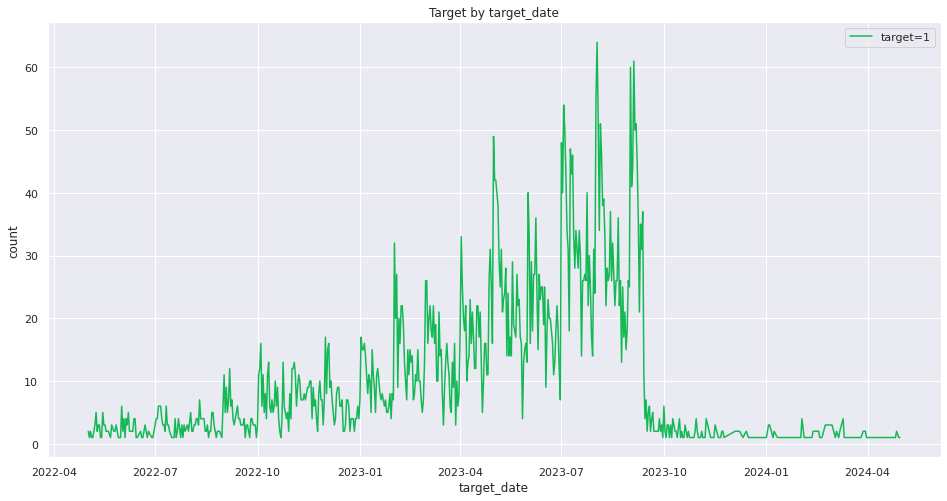

In [58]:
sns.set(rc = {'figure.figsize':(16,8)})
sns.lineplot(x = 'target_date', y = 'count', data = target_by_target_date, label = 'target=1', color=color[9])
plt.legend()
plt.title('Target by target_date')
plt.show()

# `train_cleaned`

In [9]:
train = train[train.target_month != '2022-05-01']
train.target_month.min()

'2022-06-01'

In [12]:
# (train.isna().sum() / len(train)).rename('percent of NA').to_frame() \
#     .sort_values(by = ['percent of NA'], ascending = False) \
#     .style.bar(vmax=1, vmin=0).format('{:.2%}')

In [20]:
target_cols = ['target_date', 'target_date_timestamp']

cols_to_delete = [i for i in train.loc[:, train.isnull().mean() > .3].columns.to_list()
                          if i not in target_cols]

print('train_data:', train.shape)
print('target_cols:', len(target_cols))
print('cols_to_delete:', len(cols_to_delete))
print('train_data_cleaned:', train.drop(columns = target_cols + cols_to_delete).shape)

train_data: (16627, 593)
target_cols: 2
cols_to_delete: 294
train_data_cleaned: (16627, 297)


In [21]:
train_cleaned = train.drop(columns = target_cols + cols_to_delete)

In [67]:
y_train = train_cleaned.target
X_train = train_cleaned.drop(columns = 'target')
y_train.shape, X_train.shape

((16627,), (16627, 296))

# `test_cleaned`

In [23]:
test_cleaned = test.drop(columns = target_cols + cols_to_delete)

In [68]:
y_test = test_cleaned.target
X_test = test_cleaned.drop(columns = 'target')
y_test.shape, X_test.shape

((4157,), (4157, 296))

# `Pipeline()` Preprocessing

In [25]:
numerical_features = X_train.select_dtypes(include=['number']).columns.to_list()
categorical_features = X_train.select_dtypes(include=['object']).columns.to_list()
len(numerical_features), len(categorical_features)

(262, 34)

In [26]:
%%time
for column in categorical_features:
    
    X_train[column].fillna('Missing', inplace=True)
    X_test[column].fillna('Missing', inplace=True)
    
# for column in [categorical_feature for categorical_feature in categorical_features
#                         if categorical_feature in X_train.loc[:, X_train.isnull().mean() > 0].columns.to_list()]:

CPU times: user 94.5 ms, sys: 32.4 ms, total: 127 ms
Wall time: 126 ms


# `XGBoost()` FINAL

In [12]:
X = pd.read_parquet('/home/jovyan/__RAYDTT/bs_segments_new/train_upd.parquet')

X = X.drop(columns=['target_date', 'target_date_timestamp'])

X = X[(X.target_month>'2022-05-01') & (X.target_month<='2023-09-01')]

In [13]:
X_train = X[X.target_month<'2023-08-01']
cols_to_stay = [i for i in X_train.loc[:, X_train.isnull().mean() < .3].columns.to_list()]
X_train = X_train[cols_to_stay]
categorical_features = X_train.select_dtypes(include=['object']).columns.to_list()

In [14]:
X['temp'] = X['target_month']

for col in categorical_features:
    le = LabelEncoder()
    X[col] = X[col].astype(str).fillna('Missing')
    X[col] = le.fit_transform(X[col])

In [15]:
del X_train
gc.collect()

0

In [16]:
X_train, X_valid, X_test = X[X.temp<'2023-08-01'], X[X.temp=='2023-08-01'], X[X.temp=='2023-09-01']

In [17]:
X_train = X_train[cols_to_stay]
X_valid = X_valid[cols_to_stay]
X_test = X_test[cols_to_stay]

In [18]:
X_train.shape, X_valid.shape, X_test.shape

((414989, 273), (72390, 273), (75127, 273))

In [19]:
# ресэмплинг целевого класса для тренировочной части
train_proba_thershold = len(X_train[X_train.target==1])/len(X_train)
train_n_samples = 50

train_splits = process_by_split(
    X_train, # df
    X_train,  # df
    target_class=1,
    target_name='target', # target name     
    avg_proba_thershold=train_proba_thershold*(1+1e-9),
    num_of_samples=train_n_samples,
    random_seed = 42
)

for i in range(train_n_samples-1):
    print('avg_target_proba:', len(train_splits[i][train_splits[i].target==1])/len(train_splits[i]), '| shape:', len(train_splits[i]))

avg_target_proba: 0.012019595700126992 | shape: 414989
avg_target_proba: 0.032182513823383295 | shape: 154991
avg_target_proba: 0.05234547171791374 | shape: 95290
avg_target_proba: 0.07250843121293174 | shape: 68792
avg_target_proba: 0.09267069205759405 | shape: 53825
avg_target_proba: 0.11283280928359762 | shape: 44207
avg_target_proba: 0.13299560058658846 | shape: 37505
avg_target_proba: 0.15316117542297417 | shape: 32567
avg_target_proba: 0.1733208242120991 | shape: 28779
avg_target_proba: 0.1934833204034135 | shape: 25780
avg_target_proba: 0.21364629288559558 | shape: 23347
avg_target_proba: 0.23381615337739653 | shape: 21333
avg_target_proba: 0.2539714867617108 | shape: 19640
avg_target_proba: 0.27414124759549324 | shape: 18195
avg_target_proba: 0.29429464865183785 | shape: 16949
avg_target_proba: 0.31446223679233387 | shape: 15862
avg_target_proba: 0.3346303501945525 | shape: 14906
avg_target_proba: 0.3547905256419375 | shape: 14059
avg_target_proba: 0.3749530181162144 | shape: 1

In [20]:
valid_proba_thershold = len(X_valid[X_valid.target==1])/len(X_valid)
valid_n_samples = 50

valid_splits = process_by_split(
    X_train, # df
    X_valid,  # df
    target_class=1,
    target_name='target', # target name     
    avg_proba_thershold=valid_proba_thershold*(1+1e-9),
    num_of_samples=valid_n_samples,
    random_seed = 42
)

for i in range(valid_n_samples-1):
    print('avg_target_proba:', len(valid_splits[i][valid_splits[i].target==1])/len(valid_splits[i]), '| shape:', len(valid_splits[i]))

avg_target_proba: 0.013192429893631718 | shape: 72390
avg_target_proba: 0.03333100656149658 | shape: 28652
avg_target_proba: 0.05347144456886898 | shape: 17860
avg_target_proba: 0.07360875597348543 | shape: 12974
avg_target_proba: 0.09374693236477864 | shape: 10187
avg_target_proba: 0.1138938580799046 | shape: 8385
avg_target_proba: 0.13403508771929826 | shape: 7125
avg_target_proba: 0.15415657788539144 | shape: 6195
avg_target_proba: 0.17430187990509216 | shape: 5479
avg_target_proba: 0.19446141315414375 | shape: 4911
avg_target_proba: 0.2145585261738935 | shape: 4451
avg_target_proba: 0.23470140083558613 | shape: 4069
avg_target_proba: 0.2548705631171604 | shape: 3747
avg_target_proba: 0.27497840483731645 | shape: 3473
avg_target_proba: 0.29511742892459825 | shape: 3236
avg_target_proba: 0.3152855727963024 | shape: 3029
avg_target_proba: 0.3354408148928697 | shape: 2847
avg_target_proba: 0.3555472822040209 | shape: 2686
avg_target_proba: 0.37568843430369786 | shape: 2542
avg_target_p

In [21]:
print('avg_target_proba:', len(train_splits[5][train_splits[5].target==1])/len(train_splits[5]), '| shape:', len(train_splits[5]))

avg_target_proba: 0.11283280928359762 | shape: 44207


In [22]:
print('avg_target_proba:', len(valid_splits[5][valid_splits[5].target==1])/len(valid_splits[5]), '| shape:', len(valid_splits[5]))

avg_target_proba: 0.1138938580799046 | shape: 8385


In [23]:
train_split_chosen_xgb = train_splits[5]
del train_splits
gc.collect()

valid_splits_chosen_xgb = valid_splits[5]
del valid_splits
gc.collect()

del X, X_train, X_valid
gc.collect()

0

In [24]:
train_split_chosen_xgb.shape, valid_splits_chosen_xgb.shape

((44207, 273), (8385, 273))

## `XGBoost()`

In [87]:
np.random.seed(SEED)
random.seed(SEED)

In [88]:
X_train, y_train = train_split_chosen_xgb.drop(columns=['target']), train_split_chosen_xgb.target
X_valid, y_valid = valid_splits_chosen_xgb.drop(columns=['target']), valid_splits_chosen_xgb.target
X_test, y_test = X_test.drop(columns=['target']), X_test.target

In [89]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_valid, label=y_valid)
dtest = xgb.DMatrix(X_test, label=y_test)

In [90]:
params = {
            'alpha': 2.173723e-01,
            'booster': "gblinear",
            'colsample_bytree': 0.967863,
            'lambda': 1.627248e-01,
            'random_state': 42,
            'subsample': 0.785626,
            'verbosity': 0,
            'objective': 'binary:logistic',
            'tree_method': 'exact',
            'seed': SEED
          }

num_boost_round = 287
early_stopping_rounds = 200

In [91]:
%%time
xgboost = xgb.train(params, 
                    dtrain, 
                    num_boost_round=num_boost_round,
                    evals=[(dvalid, 'validation')], 
                    early_stopping_rounds=early_stopping_rounds,
                    verbose_eval=False)

CPU times: user 1min, sys: 0 ns, total: 1min
Wall time: 4.34 s


In [92]:
%%time
xgboost_proba_train = xgboost.predict(dtrain, iteration_range=(0, xgboost.best_iteration + 1))
xgboost_pred_train = np.rint(xgboost_proba_train)

xgboost_proba_valid = xgboost.predict(dvalid, iteration_range=(0, xgboost.best_iteration + 1))
xgboost_pred_valid = np.rint(xgboost_proba_valid)

xgboost_proba_test = xgboost.predict(dtest, iteration_range=(0, xgboost.best_iteration + 1))
xgboost_pred_test = np.rint(xgboost_proba_test)

CPU times: user 326 ms, sys: 0 ns, total: 326 ms
Wall time: 28 ms


In [93]:
xgboost_pred_train.sum(), y_train.sum(),\
xgboost_pred_valid.sum(), y_valid.sum(),\
xgboost_pred_test.sum(), y_test.sum()

(263.0, 4988, 100.0, 955, 612.0, 578)

In [68]:
pickle.dump(xgboost, open(r'pickles/xgboost_model.pickle.dat','wb')) 

In [69]:
!cd pickles; ls -a

.   catboost_model.pickle.dat	   svarygin_2105_catboost_model.pickle.dat
..  catboost_model_upd.pickle.dat  xgboost_model.pickle.dat


## Train Metrics

In [94]:
accuracy = accuracy_score(y_train, xgboost_pred_train)
balanced_accuracy = balanced_accuracy_score(y_train, xgboost_pred_train)
average_precision = average_precision_score(y_train, xgboost_proba_train)
recall = recall_score(y_train, xgboost_pred_train)
precision = precision_score(y_train, xgboost_pred_train)
roc_auc = roc_auc_score(y_train, xgboost_proba_train)
f1 = f1_score(y_train, xgboost_pred_train)

precision_points, recall_points, _ = precision_recall_curve(y_train, xgboost_proba_train) 
prc_auc = auc(recall_points, precision_points)

print('Accuracy:', np.round(accuracy, 3))
print('Balanced accuracy:', np.round(balanced_accuracy, 3))
print('Average precision:', np.round(average_precision, 3))
print('Recall:', np.round(recall, 3))
print('Precision:', np.round(precision, 3))
print('F1:', np.round(f1, 3))
print('ROC AUC:', np.round(roc_auc, 3))
print('PRC AUC:', np.round(prc_auc, 3))

Accuracy: 0.887
Balanced accuracy: 0.51
Average precision: 0.267
Recall: 0.024
Precision: 0.456
F1: 0.046
ROC AUC: 0.729
PRC AUC: 0.266


In [84]:
# plot_roc_curve(y_train, xgboost_proba_train)

In [95]:
get_reports(np.where(xgboost_proba_train == 1.0, 0.9999, xgboost_proba_train), y_train)

ROC AUC: 0.729


,top 1%,top 3%,top 5%,top 10%,top 15%,top 20%,top 30%,top 40%,top 50%,top 60%,top 70%,top 80%,top 90%,top 100%
LIFT,3.921,3.513,3.311,2.999,2.589,2.351,1.971,1.732,1.559,1.406,1.283,1.180,1.087,1.000
PRECISION,0.442,0.396,0.374,0.338,0.292,0.265,0.222,0.195,0.176,0.159,0.145,0.133,0.123,0.113
RECALL,0.039,0.105,0.166,0.300,0.388,0.470,0.591,0.693,0.779,0.844,0.898,0.944,0.979,1.000
COUNT,443.000,1327.000,2211.000,4421.000,6631.000,8842.000,13262.000,17683.000,22103.000,26524.000,30945.000,35365.000,39786.000,44205.000


## Valid Metrics

In [96]:
accuracy = accuracy_score(y_valid, xgboost_pred_valid)
balanced_accuracy = balanced_accuracy_score(y_valid, xgboost_pred_valid)
average_precision = average_precision_score(y_valid, xgboost_proba_valid)
recall = recall_score(y_valid, xgboost_pred_valid)
precision = precision_score(y_valid, xgboost_pred_valid)
roc_auc = roc_auc_score(y_valid, xgboost_proba_valid)
f1 = f1_score(y_valid, xgboost_pred_valid)

precision_points, recall_points, _ = precision_recall_curve(y_valid, xgboost_proba_valid) 
prc_auc = auc(recall_points, precision_points)

print('Accuracy:', np.round(accuracy, 3))
print('Balanced accuracy:', np.round(balanced_accuracy, 3))
print('Average precision:', np.round(average_precision, 3))
print('Recall:', np.round(recall, 3))
print('Precision:', np.round(precision, 3))
print('F1:', np.round(f1, 3))
print('ROC AUC:', np.round(roc_auc, 3))
print('PRC AUC:', np.round(prc_auc, 3))

Accuracy: 0.884
Balanced accuracy: 0.518
Average precision: 0.248
Recall: 0.044
Precision: 0.42
F1: 0.08
ROC AUC: 0.707
PRC AUC: 0.247


In [83]:
# plot_roc_curve(y_valid, xgboost_proba_valid)

In [97]:
get_reports(xgboost_proba_valid, y_valid)

ROC AUC: 0.707


,top 1%,top 3%,top 5%,top 10%,top 15%,top 20%,top 30%,top 40%,top 50%,top 60%,top 70%,top 80%,top 90%,top 100%
LIFT,3.763,3.345,2.969,2.731,2.429,2.199,1.940,1.686,1.510,1.375,1.258,1.156,1.076,1.000
PRECISION,0.429,0.381,0.338,0.311,0.277,0.250,0.221,0.192,0.172,0.157,0.143,0.132,0.123,0.114
RECALL,0.038,0.101,0.149,0.273,0.364,0.440,0.582,0.674,0.755,0.825,0.881,0.925,0.969,1.000
COUNT,84.000,252.000,420.000,839.000,1258.000,1677.000,2516.000,3354.000,4192.000,5031.000,5869.000,6708.000,7546.000,8384.000


## Test Metrics

In [160]:
accuracy = accuracy_score(y_test, xgboost_pred_test)
balanced_accuracy = balanced_accuracy_score(y_test, xgboost_pred_test)
average_precision = average_precision_score(y_test, xgboost_proba_test)
recall = recall_score(y_test, xgboost_pred_test)
precision = precision_score(y_test, xgboost_pred_test)
roc_auc = roc_auc_score(y_test, xgboost_proba_test)
f1 = f1_score(y_test, xgboost_pred_test)

precision_points, recall_points, _ = precision_recall_curve(y_test, xgboost_proba_test) 
prc_auc = auc(recall_points, precision_points)

print('Accuracy:', np.round(accuracy, 3))
print('Balanced accuracy:', np.round(balanced_accuracy, 3))
print('Average precision:', np.round(average_precision, 3))
print('Recall:', np.round(recall, 3))
print('Precision:', np.round(precision, 3))
print('F1:', np.round(f1, 3))
print('ROC AUC:', np.round(roc_auc, 3))
print('PRC AUC:', np.round(prc_auc, 3))

Accuracy: 0.985
Balanced accuracy: 0.525
Average precision: 0.026
Recall: 0.057
Precision: 0.054
F1: 0.056
ROC AUC: 0.738
PRC AUC: 0.026


In [82]:
# plot_roc_curve(y_test, xgboost_proba_test)

In [161]:
get_reports(np.where(xgboost_proba_test == 1.0, 0.9999, xgboost_proba_test), y_test)

ROC AUC: 0.738


,top 1%,top 3%,top 5%,top 10%,top 15%,top 20%,top 30%,top 40%,top 50%,top 60%,top 70%,top 80%,top 90%,top 100%
LIFT,6.568,5.594,5.362,3.962,3.172,2.699,2.134,1.782,1.585,1.442,1.307,1.207,1.094,1.000
PRECISION,0.051,0.043,0.041,0.030,0.024,0.021,0.016,0.014,0.012,0.011,0.010,0.009,0.008,0.008
RECALL,0.066,0.168,0.268,0.396,0.476,0.540,0.640,0.713,0.792,0.865,0.915,0.965,0.984,1.000
COUNT,752.000,2254.000,3757.000,7513.000,11269.000,15026.000,22538.000,30051.000,37563.000,45076.000,52589.000,60101.000,67614.000,75124.000


## by tops

In [145]:
X_test.target_month

27        2023-09-01
35        2023-09-01
40        2023-09-01
103       2023-09-01
121       2023-09-01
             ...    
766151    2023-09-01
766204    2023-09-01
766293    2023-09-01
766331    2023-09-01
768605    2023-09-01
Name: target_month, Length: 75127, dtype: object

In [98]:
xgboost_pred_test.shape, y_test.shape,\
xgboost_pred_test.sum(), y_test.sum()

((75127,), (75127,), 612.0, 578)

In [99]:
results_df = pd.DataFrame({
    'Real Label': y_test,
    'Predicted Probability': xgboost_proba_test
})

results_df.sort_values(by = ['Predicted Probability'], ascending = False)

,Real Label,Predicted Probability
486891,0,1.000000e+00
450635,0,1.000000e+00
361039,0,1.000000e+00
725062,0,1.000000e+00
665173,0,1.000000e+00
...,...,...
629524,0,2.223863e-07
524929,0,5.247454e-08
27863,0,2.391016e-17
428652,0,1.375313e-19


In [136]:
top_1_percent_index = int(len(results_df) * 0.01)
top_1_percent_df = results_df.head(top_1_percent_index if top_1_percent_index > 0 else 1)

# Calculate the average precision score for the top 1% predictions
average_precision = average_precision_score(top_1_percent_df['Real Label'], top_1_percent_df['Predicted Probability'])
average_precision

0.26517883950359855

# `CatBoostClassifier()` FINAL

In [13]:
X = pd.read_parquet('/home/jovyan/__RAYDTT/bs_segments_new/train_upd.parquet')

X = X.drop(columns=['target_date', 'target_date_timestamp'])

X = X[(X.target_month>'2022-05-01') & (X.target_month<='2023-09-01')]

In [14]:
X_train = X[X.target_month<'2023-08-01']
cols_to_stay = [i for i in X_train.loc[:, X_train.isnull().mean() < .3].columns.to_list()]
X_train = X_train[cols_to_stay]
categorical_features = X_train.select_dtypes(include=['object']).columns.to_list()
del X_train
gc.collect()

538

In [15]:
X_train, X_valid, X_test = X[X.target_month<'2023-08-01'], X[X.target_month=='2023-08-01'], X[X.target_month=='2023-09-01']

In [16]:
%%time
for column in categorical_features:
    X_train[column].fillna('Missing', inplace=True)
    X_valid[column].fillna('Missing', inplace=True)
    X_test[column].fillna('Missing', inplace=True)

CPU times: user 3.96 s, sys: 3.72 s, total: 7.68 s
Wall time: 7.69 s


In [17]:
X_train = X_train[cols_to_stay]
X_valid = X_valid[cols_to_stay]
X_test = X_test[cols_to_stay]
X_train.shape, X_valid.shape, X_test.shape

((414989, 273), (72390, 273), (75127, 273))

In [18]:
# ресэмплинг целевого класса для тренировочной части
train_proba_thershold = len(X_train[X_train.target==1])/len(X_train)
train_n_samples = 50

train_splits = process_by_split(
    X_train, # df
    X_train,  # df
    target_class=1,
    target_name='target', # target name     
    avg_proba_thershold=train_proba_thershold*(1+1e-9),
    num_of_samples=train_n_samples,
    random_seed = 42
)

for i in range(train_n_samples-1):
    print('avg_target_proba:', len(train_splits[i][train_splits[i].target==1])/len(train_splits[i]), '| shape:', len(train_splits[i]))

avg_target_proba: 0.012019595700126992 | shape: 414989
avg_target_proba: 0.032182513823383295 | shape: 154991
avg_target_proba: 0.05234547171791374 | shape: 95290
avg_target_proba: 0.07250843121293174 | shape: 68792
avg_target_proba: 0.09267069205759405 | shape: 53825
avg_target_proba: 0.11283280928359762 | shape: 44207
avg_target_proba: 0.13299560058658846 | shape: 37505
avg_target_proba: 0.15316117542297417 | shape: 32567
avg_target_proba: 0.1733208242120991 | shape: 28779
avg_target_proba: 0.1934833204034135 | shape: 25780
avg_target_proba: 0.21364629288559558 | shape: 23347
avg_target_proba: 0.23381615337739653 | shape: 21333
avg_target_proba: 0.2539714867617108 | shape: 19640
avg_target_proba: 0.27414124759549324 | shape: 18195
avg_target_proba: 0.29429464865183785 | shape: 16949
avg_target_proba: 0.31446223679233387 | shape: 15862
avg_target_proba: 0.3346303501945525 | shape: 14906
avg_target_proba: 0.3547905256419375 | shape: 14059
avg_target_proba: 0.3749530181162144 | shape: 1

In [19]:
valid_proba_thershold = len(X_valid[X_valid.target==1])/len(X_valid)
valid_n_samples = 50

valid_splits = process_by_split(
    X_train, # df
    X_valid,  # df
    target_class=1,
    target_name='target', # target name     
    avg_proba_thershold=valid_proba_thershold*(1+1e-9),
    num_of_samples=valid_n_samples,
    random_seed = 42
)

for i in range(valid_n_samples-1):
    print('avg_target_proba:', len(valid_splits[i][valid_splits[i].target==1])/len(valid_splits[i]), '| shape:', len(valid_splits[i]))

avg_target_proba: 0.013192429893631718 | shape: 72390
avg_target_proba: 0.03333100656149658 | shape: 28652
avg_target_proba: 0.05347144456886898 | shape: 17860
avg_target_proba: 0.07360875597348543 | shape: 12974
avg_target_proba: 0.09374693236477864 | shape: 10187
avg_target_proba: 0.1138938580799046 | shape: 8385
avg_target_proba: 0.13403508771929826 | shape: 7125
avg_target_proba: 0.15415657788539144 | shape: 6195
avg_target_proba: 0.17430187990509216 | shape: 5479
avg_target_proba: 0.19446141315414375 | shape: 4911
avg_target_proba: 0.2145585261738935 | shape: 4451
avg_target_proba: 0.23470140083558613 | shape: 4069
avg_target_proba: 0.2548705631171604 | shape: 3747
avg_target_proba: 0.27497840483731645 | shape: 3473
avg_target_proba: 0.29511742892459825 | shape: 3236
avg_target_proba: 0.3152855727963024 | shape: 3029
avg_target_proba: 0.3354408148928697 | shape: 2847
avg_target_proba: 0.3555472822040209 | shape: 2686
avg_target_proba: 0.37568843430369786 | shape: 2542
avg_target_p

In [20]:
print('avg_target_proba:', len(train_splits[5][train_splits[5].target==1])/len(train_splits[5]), '| shape:', len(train_splits[5]))
print('avg_target_proba:', len(valid_splits[5][valid_splits[5].target==1])/len(valid_splits[5]), '| shape:', len(valid_splits[5]))

avg_target_proba: 0.11283280928359762 | shape: 44207
avg_target_proba: 0.1138938580799046 | shape: 8385


In [21]:
train_split_chosen_catboost = train_splits[5]
del train_splits
gc.collect()

valid_splits_chosen_catboost = valid_splits[5]
del valid_splits
gc.collect()

del X, X_train, X_valid
gc.collect()

train_split_chosen_catboost.shape, valid_splits_chosen_catboost.shape

((44207, 273), (8385, 273))

## `CatBoost()`

In [22]:
np.random.seed(SEED)
random.seed(SEED)

In [23]:
X_train, y_train = train_split_chosen_catboost.drop(columns=['target']), train_split_chosen_catboost.target
X_valid, y_valid = valid_splits_chosen_catboost.drop(columns=['target']), valid_splits_chosen_catboost.target
X_test, y_test = X_test.drop(columns=['target']), X_test.target
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test.shape

((44207, 272), (44207,), (8385, 272), (8385,), (75127, 272), (75127,))

In [ ]:
# catboost = pickle.load(open(r'/pickles/final_model_binary.pickle.dat','rb'))

In [24]:
params = {'iterations': 112,
 'objective': 'Logloss',
 'depth': 2,
 'grow_policy': 'Depthwise',
 'min_data_in_leaf': 2,
 'learning_rate': 0.08419460053799674,
 'l2_leaf_reg': 4.084821138002928,
 'bootstrap_type': 'Bayesian',
 'bagging_temperature': 6.899411355939375,
 'logging_level': 'Silent',
 'random_seed': SEED,
 'eval_metric': 'AUC',
 'early_stopping_rounds': 200,
 'cat_features': categorical_features}

In [25]:
catboost = CatBoostClassifier(**params)

In [26]:
%%time
catboost.fit(X_train, y_train)

CPU times: user 18.1 s, sys: 402 ms, total: 18.5 s
Wall time: 1.92 s


In [27]:
%%time
catboost_pred_train = catboost.predict(X_train)
catboost_proba_train = catboost.predict_proba(X_train)[:, 1]

catboost_pred_valid = catboost.predict(X_valid)
catboost_proba_valid = catboost.predict_proba(X_valid)[:, 1] 

catboost_pred_test = catboost.predict(X_test)
catboost_proba_test = catboost.predict_proba(X_test)[:, 1]

CPU times: user 2.18 s, sys: 195 ms, total: 2.38 s
Wall time: 1.11 s


In [28]:
catboost_pred_train.sum(), y_train.sum(),\
catboost_pred_valid.sum(), y_valid.sum(),\
catboost_pred_test.sum(), y_test.sum()

(166, 4988, 294, 955, 1846, 578)

In [51]:
pickle.dump(catboost, open(r'pickles/catboost_model_final.pickle.dat','wb')) 

In [26]:
!cd pickles; ls -a

.				 catboost_model_upd.pickle.dat
..				 svarygin_2105_catboost_model.pickle.dat
catboost_model_final.pickle.dat  xgboost_model.pickle.dat
catboost_model.pickle.dat


## Train Metrics

In [29]:
accuracy = accuracy_score(y_train, catboost_pred_train)
balanced_accuracy = balanced_accuracy_score(y_train, catboost_pred_train)
average_precision = average_precision_score(y_train, catboost_proba_train)
recall = recall_score(y_train, catboost_pred_train)
precision = precision_score(y_train, catboost_pred_train)
roc_auc = roc_auc_score(y_train, catboost_proba_train)
f1 = f1_score(y_train, catboost_pred_train)

precision_points, recall_points, _ = precision_recall_curve(y_train, catboost_proba_train) 
prc_auc = auc(recall_points, precision_points)

print('Accuracy:', np.round(accuracy, 3))
print('Balanced accuracy:', np.round(balanced_accuracy, 3))
print('Average precision:', np.round(average_precision, 3))
print('Recall:', np.round(recall, 3))
print('Precision:', np.round(precision, 3))
print('F1:', np.round(f1, 3))
print('ROC AUC:', np.round(roc_auc, 3))
print('PRC AUC:', np.round(prc_auc, 3))

Accuracy: 0.888
Balanced accuracy: 0.508
Average precision: 0.288
Recall: 0.019
Precision: 0.56
F1: 0.036
ROC AUC: 0.733
PRC AUC: 0.287


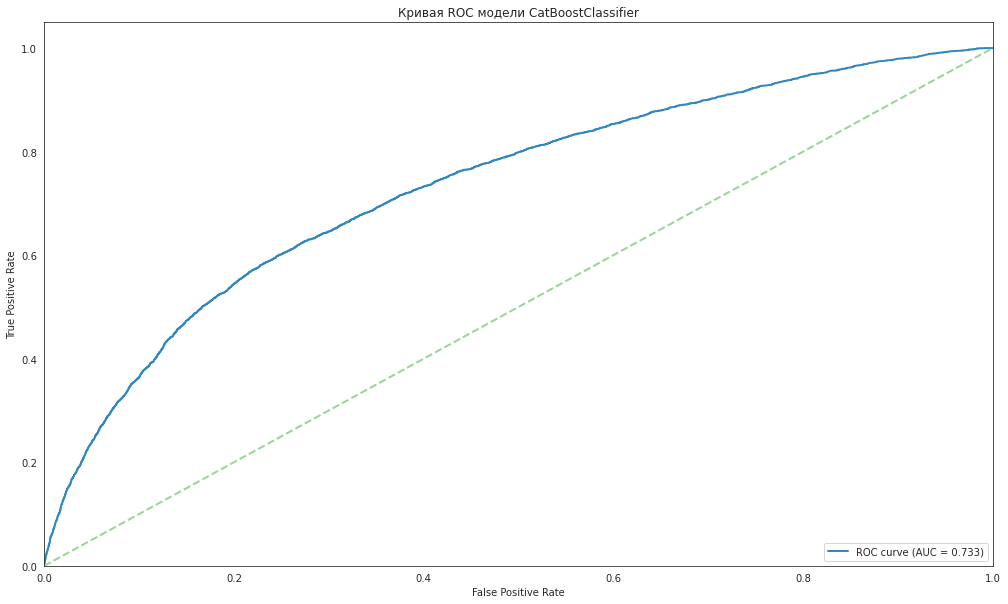

0.7328433136132957

In [30]:
plot_roc_curve(y_train, catboost_proba_train)

In [31]:
get_reports(catboost_proba_train, y_train)

ROC AUC: 0.733


,top 1%,top 3%,top 5%,top 10%,top 15%,top 20%,top 30%,top 40%,top 50%,top 60%,top 70%,top 80%,top 90%,top 100%
LIFT,4.421,3.974,3.600,3.063,2.682,2.467,2.037,1.755,1.554,1.395,1.272,1.171,1.086,1.000
PRECISION,0.499,0.448,0.406,0.346,0.303,0.278,0.230,0.198,0.175,0.157,0.144,0.132,0.123,0.113
RECALL,0.044,0.119,0.180,0.306,0.402,0.493,0.611,0.702,0.777,0.837,0.891,0.937,0.976,1.000
COUNT,443.000,1327.000,2211.000,4421.000,6631.000,8842.000,13262.000,17683.000,22103.000,26524.000,30945.000,35364.000,39728.000,44206.000


## Valid Metrics

In [32]:
accuracy = accuracy_score(y_valid, catboost_pred_valid)
balanced_accuracy = balanced_accuracy_score(y_valid, catboost_pred_valid)
average_precision = average_precision_score(y_valid, catboost_proba_valid)
recall = recall_score(y_valid, catboost_pred_valid)
precision = precision_score(y_valid, catboost_pred_valid)
roc_auc = roc_auc_score(y_valid, catboost_proba_valid)
f1 = f1_score(y_valid, catboost_pred_valid)

precision_points, recall_points, _ = precision_recall_curve(y_valid, catboost_proba_valid) 
prc_auc = auc(recall_points, precision_points)

print('Accuracy:', np.round(accuracy, 3))
print('Balanced accuracy:', np.round(balanced_accuracy, 3))
print('Average precision:', np.round(average_precision, 3))
print('Recall:', np.round(recall, 3))
print('Precision:', np.round(precision, 3))
print('F1:', np.round(f1, 3))
print('ROC AUC:', np.round(roc_auc, 3))
print('PRC AUC:', np.round(prc_auc, 3))

Accuracy: 0.879
Balanced accuracy: 0.549
Average precision: 0.261
Recall: 0.121
Precision: 0.395
F1: 0.186
ROC AUC: 0.709
PRC AUC: 0.26


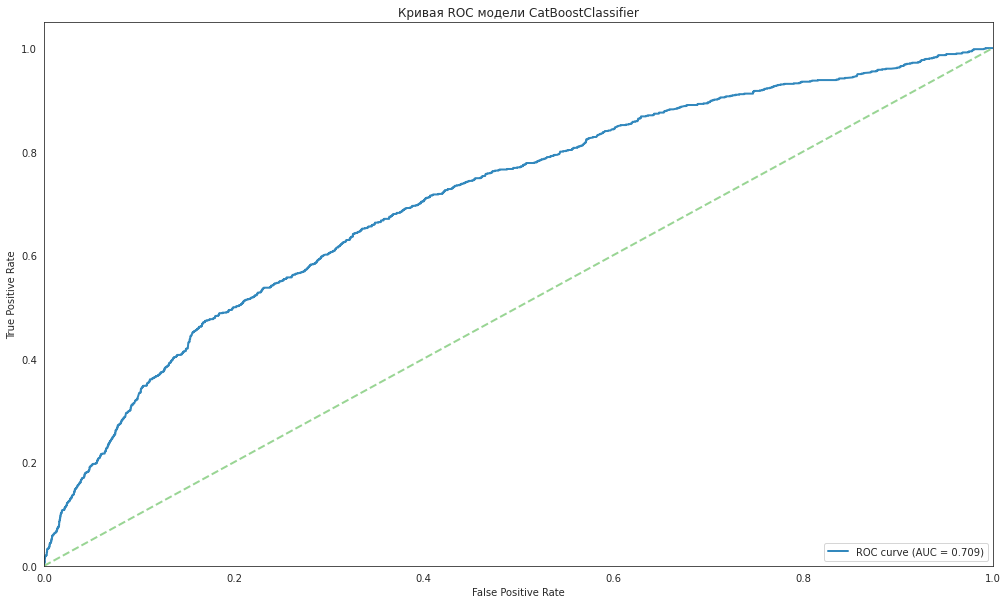

0.7088791019850191

In [33]:
plot_roc_curve(y_valid, catboost_proba_valid)

In [34]:
get_reports(catboost_proba_valid, y_valid)

ROC AUC: 0.709


,top 1%,top 3%,top 5%,top 10%,top 15%,top 20%,top 30%,top 40%,top 50%,top 60%,top 70%,top 80%,top 90%,top 100%
LIFT,4.286,3.589,3.136,2.710,2.464,2.319,1.881,1.686,1.514,1.370,1.269,1.164,1.067,1.000
PRECISION,0.488,0.409,0.357,0.309,0.281,0.264,0.214,0.192,0.172,0.156,0.144,0.133,0.122,0.114
RECALL,0.043,0.108,0.157,0.271,0.370,0.464,0.564,0.674,0.757,0.822,0.888,0.931,0.960,1.000
COUNT,84.000,252.000,420.000,839.000,1258.000,1677.000,2516.000,3354.000,4192.000,5031.000,5869.000,6704.000,7546.000,8384.000


## Test Metrics

In [35]:
accuracy = accuracy_score(y_test, catboost_pred_test)
balanced_accuracy = balanced_accuracy_score(y_test, catboost_pred_test)
average_precision = average_precision_score(y_test, catboost_proba_test)
recall = recall_score(y_test, catboost_pred_test)
precision = precision_score(y_test, catboost_pred_test)
roc_auc = roc_auc_score(y_test, catboost_proba_test)
f1 = f1_score(y_test, catboost_pred_test)

precision_points, recall_points, _ = precision_recall_curve(y_test, catboost_proba_test) 
prc_auc = auc(recall_points, precision_points)

print('Accuracy:', np.round(accuracy, 3))
print('Balanced accuracy:', np.round(balanced_accuracy, 3))
print('Average precision:', np.round(average_precision, 3))
print('Recall:', np.round(recall, 3))
print('Precision:', np.round(precision, 3))
print('F1:', np.round(f1, 3))
print('ROC AUC:', np.round(roc_auc, 3))
print('PRC AUC:', np.round(prc_auc, 3))

Accuracy: 0.97
Balanced accuracy: 0.563
Average precision: 0.028
Recall: 0.151
Precision: 0.047
F1: 0.072
ROC AUC: 0.744
PRC AUC: 0.028


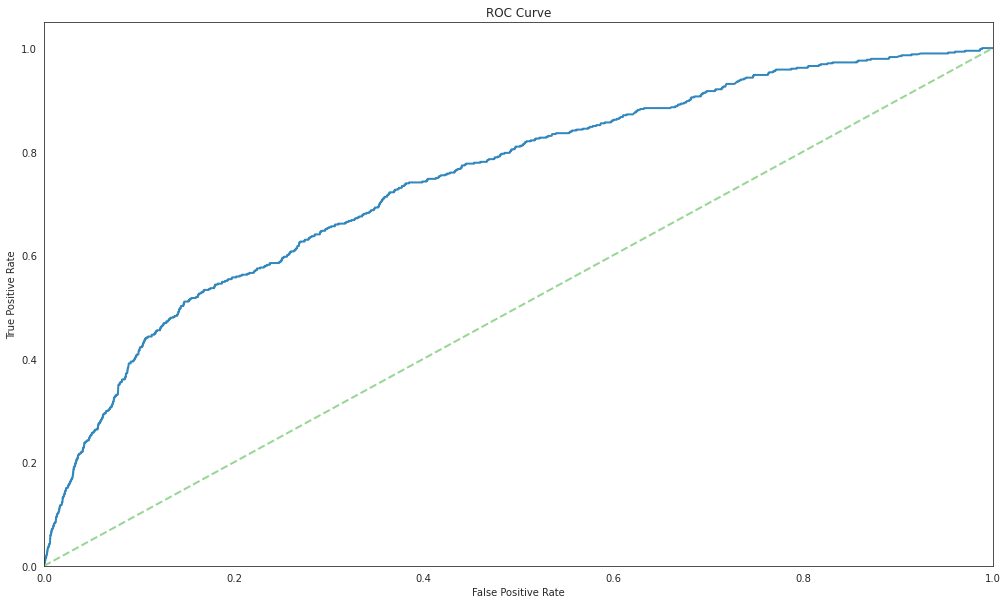

0.744195905426407

In [41]:
plot_roc_curve(y_test, catboost_proba_test)

In [37]:
get_reports(catboost_proba_test, y_test)

ROC AUC: 0.744


,top 1%,top 3%,top 5%,top 10%,top 15%,top 20%,top 30%,top 40%,top 50%,top 60%,top 70%,top 80%,top 90%,top 100%
LIFT,7.605,5.536,5.016,4.066,3.379,2.768,2.168,1.851,1.619,1.430,1.310,1.202,1.092,1.000
PRECISION,0.059,0.043,0.039,0.031,0.026,0.021,0.017,0.014,0.012,0.011,0.010,0.009,0.008,0.008
RECALL,0.076,0.166,0.251,0.407,0.507,0.554,0.651,0.740,0.810,0.858,0.917,0.962,0.983,1.000
COUNT,752.000,2254.000,3757.000,7513.000,11269.000,15026.000,22538.000,30051.000,37563.000,45075.000,52589.000,60098.000,67596.000,75126.000


## BY TOPS

In [27]:
catboost_pred_test.shape, y_test.shape,\
catboost_pred_test.sum(), y_test.sum()

((75127,), (75127,), 1846, 578)

In [96]:
def get_reports_vs_all(y_pred, y_true, perc=[0.01, 0.05]):
    
    metrics = {}
    y_pred = pd.Series(y_pred)
    y_true = pd.Series(y_true)

    for p in perc:

        thr = y_pred.quantile(1-p)
        
        precision = precision_score(y_true, np.round(y_pred-thr+0.5))
        recall = recall_score(y_true, np.round(y_pred-thr+0.5))
        f1 = f1_score(y_true, np.round(y_pred-thr+0.5))
        average_precision = average_precision_score(y_true, (y_pred-thr+0.5))
        roc_auc = roc_auc_score(y_true, (y_pred-thr+0.5))
        
        metrics[f'{int(p*100)}_perc_top_precision_vs_all'] = precision
        metrics[f'{int(p*100)}_perc_top_recall_vs_all'] = recall
        metrics[f'{int(p*100)}_perc_top_f1_vs_all'] = f1  
        metrics[f'{int(p*100)}_perc_top_average_precision_vs_all'] = average_precision
        metrics[f'{int(p*100)}_perc_top_roc_auc_vs_all'] = roc_auc
    
    return metrics

In [100]:
def get_reports_vs_within(y_pred, y_true, perc=[0.01, 0.05]):
    
    metrics = {}
    
    results_df = pd.DataFrame({
    'Real Label': y_true,
    'Predicted Probability': y_pred,
    'Predicted Label': np.round(y_pred)
    })
    results_df = results_df.sort_values(by = ['Predicted Probability'], ascending = False)
    
    for p in perc:
    
        percent_df = results_df.head(int(len(results_df) * round(p,3)))

        precision = precision_score(percent_df['Real Label'], percent_df['Predicted Label'])
        recall = recall_score(percent_df['Real Label'], percent_df['Predicted Label'])  
        f1 = f1_score(percent_df['Real Label'], percent_df['Predicted Label'])
        average_precision = average_precision_score(percent_df['Real Label'], percent_df['Predicted Probability'])
        roc_auc = roc_auc_score(percent_df['Real Label'], percent_df['Predicted Probability'])
        
        metrics[f'{int(p*100)}_perc_top_precision_vs_within'] = precision
        metrics[f'{int(p*100)}_perc_top_recall_vs_within'] = recall
        metrics[f'{int(p*100)}_perc_top_f1_vs_within'] = f1  
        metrics[f'{int(p*100)}_perc_top_average_precision_vs_within'] = average_precision
        metrics[f'{int(p*100)}_perc_top_roc_auc_vs_within'] = roc_auc
    
    return metrics

In [106]:
def get_reports_new(y_pred, y_true, perc=[0.01, 0.05]):
    
    metrics = {}
    
    y_pred_1 = pd.Series(y_pred)
    y_true_1 = pd.Series(y_true)

    for p in perc:

        thr = y_pred_1.quantile(1-p)
        
        precision = precision_score(y_true_1, np.round(y_pred_1-thr+0.5))
        recall = recall_score(y_true_1, np.round(y_pred_1-thr+0.5))
        f1 = f1_score(y_true_1, np.round(y_pred_1-thr+0.5))
        average_precision = average_precision_score(y_true_1, (y_pred_1-thr+0.5))
        roc_auc = roc_auc_score(y_true_1, (y_pred_1-thr+0.5))
        
        metrics[f'{int(p*100)}_perc_top_precision_vs_all'] = precision
        metrics[f'{int(p*100)}_perc_top_recall_vs_all'] = recall
        metrics[f'{int(p*100)}_perc_top_f1_vs_all'] = f1  
        metrics[f'{int(p*100)}_perc_top_average_precision_vs_all'] = average_precision
        metrics[f'{int(p*100)}_perc_top_roc_auc_vs_all'] = roc_auc
        
    results_df = pd.DataFrame({
            'Real Label': y_true,
            'Predicted Probability': y_pred,
            'Predicted Label': np.round(y_pred)
            })
    results_df = results_df.sort_values(by = ['Predicted Probability'], ascending = False)
    
    for p in perc:
    
        percent_df = results_df.head(int(len(results_df) * round(p,3)))

        precision = precision_score(percent_df['Real Label'], percent_df['Predicted Label'])
        recall = recall_score(percent_df['Real Label'], percent_df['Predicted Label'])  
        f1 = f1_score(percent_df['Real Label'], percent_df['Predicted Label'])
        average_precision = average_precision_score(percent_df['Real Label'], percent_df['Predicted Probability'])
        roc_auc = roc_auc_score(percent_df['Real Label'], percent_df['Predicted Probability'])
        
        metrics[f'{int(p*100)}_perc_top_precision_vs_within'] = precision
        metrics[f'{int(p*100)}_perc_top_recall_vs_within'] = recall
        metrics[f'{int(p*100)}_perc_top_f1_vs_within'] = f1  
        metrics[f'{int(p*100)}_perc_top_average_precision_vs_within'] = average_precision
        metrics[f'{int(p*100)}_perc_top_roc_auc_vs_within'] = roc_auc
    
    return metrics

In [121]:
row = get_reports_new(catboost_proba_test, y_test)
row

{'1_perc_top_precision_vs_all': 0.05851063829787234,
 '1_perc_top_recall_vs_all': 0.07612456747404844,
 '1_perc_top_f1_vs_all': 0.0661654135338346,
 '1_perc_top_average_precision_vs_all': 0.02842177900773402,
 '1_perc_top_roc_auc_vs_all': 0.744195905426407,
 '5_perc_top_precision_vs_all': 0.038594623369709875,
 '5_perc_top_recall_vs_all': 0.2508650519031142,
 '5_perc_top_f1_vs_all': 0.06689734717416379,
 '5_perc_top_average_precision_vs_all': 0.02842177900773402,
 '5_perc_top_roc_auc_vs_all': 0.744195905426407,
 '1_perc_top_precision_vs_within': 0.05725699067909454,
 '1_perc_top_recall_vs_within': 1.0,
 '1_perc_top_f1_vs_within': 0.10831234256926953,
 '1_perc_top_average_precision_vs_within': 0.06714798466479338,
 '1_perc_top_roc_auc_vs_within': 0.5309420575482854,
 '5_perc_top_precision_vs_within': 0.047128927410617555,
 '5_perc_top_recall_vs_within': 0.6,
 '5_perc_top_f1_vs_within': 0.0873932697137117,
 '5_perc_top_average_precision_vs_within': 0.05259097313414761,
 '5_perc_top_roc_a

In [194]:
from sklearn.metrics import confusion_matrix

In [195]:
conf_matrix = confusion_matrix(y_test, catboost_pred_test)
conf_matrix

array([[72790,  1759],
       [  491,    87]])

Confusion Matrix (Tabular):
          Predicted 0  Predicted 1
Actual 0        72790         1759
Actual 1          491           87


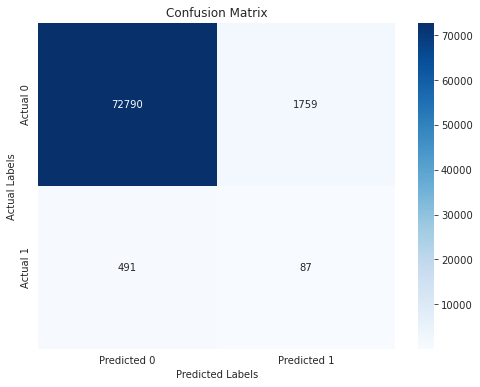

In [196]:
conf_matrix_df = pd.DataFrame(conf_matrix, index=['Actual 0', 'Actual 1'], columns=['Predicted 0', 'Predicted 1'])
print("Confusion Matrix (Tabular):")
print(conf_matrix_df)

# Using seaborn and matplotlib for graphical visualization
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.title('Confusion Matrix')
plt.show()

In [1]:
params

NameError: name 'params' is not defined

## SHAP

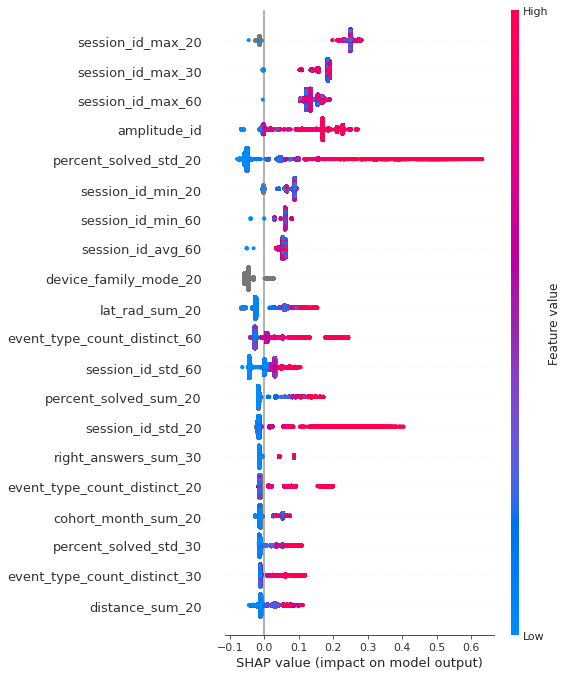

CPU times: user 35.9 s, sys: 5.4 s, total: 41.3 s
Wall time: 13.2 s


In [42]:
%%time
explainer = shap.TreeExplainer(catboost)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type='dot') # use this easier

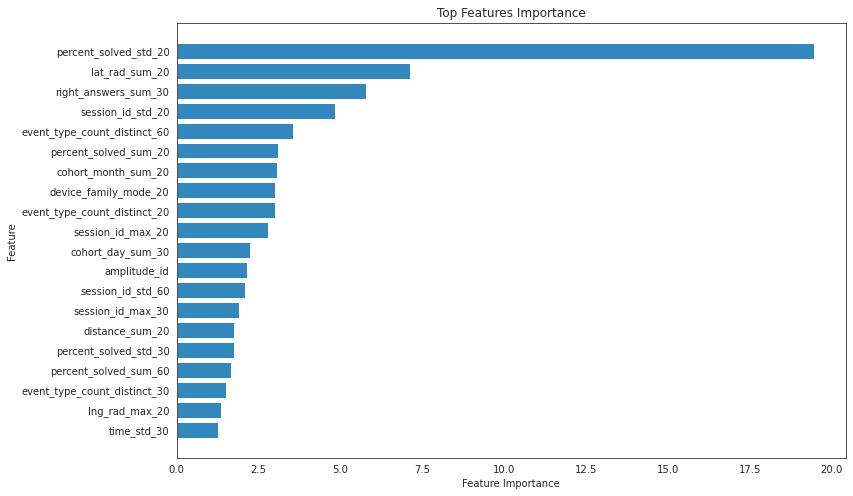

CPU times: user 228 ms, sys: 216 ms, total: 443 ms
Wall time: 169 ms


In [42]:
%%time
feature_importance = catboost.get_feature_importance()
feature_names = X_train.columns
sorted_feature_importance = sorted(zip(feature_names, feature_importance), key=lambda x: x[1], reverse=True)

top_40_features = [feature for feature, importance in sorted_feature_importance[:20]]
top_40_importance = [importance for feature, importance in sorted_feature_importance[:20]]

plt.figure(figsize=(12, 8))
plt.barh(top_40_features, top_40_importance, color=color[0]) # '#74197f','#14b956'
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top Features Importance')
plt.gca().invert_yaxis()  # Invert y-axis to display the most important features at the top
plt.show()

--------

# `CatBoostClassifier()` Model

In [48]:
catboost = pickle.load(open(r'/pickles/final_model_binary.pickle.dat','rb'))

In [101]:
!cd pickles; ls -a

.   catboost_model.pickle.dat	   svarygin_2105_catboost_model.pickle.dat
..  catboost_model_upd.pickle.dat  xgboost_model.pickle.dat


In [34]:
catboost = CatBoostClassifier(iterations = 700, 
                              depth = 10,
                              l2_leaf_reg = 7,
                              learning_rate = 0.05,
                              logging_level='Silent', 
                              cat_features = categorical_features,
                              #use_best_model=True,
                              early_stopping_rounds=10,
                              eval_metric='AUC',
                              loss_function='CrossEntropy',
                              random_seed = SEED)

In [35]:
%%time
catboost.fit(X_train, y_train)

CPU times: user 17min 53s, sys: 27 s, total: 18min 20s
Wall time: 1min 27s


In [36]:
%%time
catboost_pred_train = catboost.predict(X_train)
catboost_proba_train = catboost.predict_proba(X_train)
catboost_proba_train = catboost.predict_proba(X_train)[:, 1] 

CPU times: user 2.1 s, sys: 97.3 ms, total: 2.2 s
Wall time: 434 ms


In [37]:
%%time
catboost_pred_test =catboost.predict(X_test)
catboost_proba_test = catboost.predict_proba(X_test)
catboost_proba_test = catboost.predict_proba(X_test)[:, 1] 

CPU times: user 486 ms, sys: 24.6 ms, total: 510 ms
Wall time: 137 ms


In [39]:
catboost_pred_train.sum(), y_train.sum(),\
catboost_pred_test.sum(), y_test.sum()

(3990, 4988, 744, 208)

In [29]:
pickle.dump(catboost, open(r'pickles/svarygin_2105_catboost_model.pickle.dat','wb')) 

In [53]:
!cd pickles; ls -a

.   catboost_model.pickle.dat	   svarygin_2105_catboost_model.pickle.dat
..  catboost_model_upd.pickle.dat


## Train metrics

In [ ]:
# ROC AUC 805 738

In [40]:
accuracy = accuracy_score(y_train, catboost_pred_train)
recall = recall_score(y_train, catboost_pred_train)
precision = precision_score(y_train, catboost_pred_train)
roc_auc = roc_auc_score(y_train, catboost_proba_train)

precision_points, recall_points, _ = precision_recall_curve(y_train, catboost_proba_train) 
prc_auc = auc(recall_points, precision_points)

print('Accuracy:', np.round(accuracy, 3))
print('Recall:', np.round(recall, 3))
print('Precision:', np.round(precision, 3))
print('ROC AUC:', np.round(roc_auc, 3))
print('PRC AUC:', np.round(prc_auc, 3))

Accuracy: 0.911
Recall: 0.752
Precision: 0.941
ROC AUC: 0.969
PRC AUC: 0.939


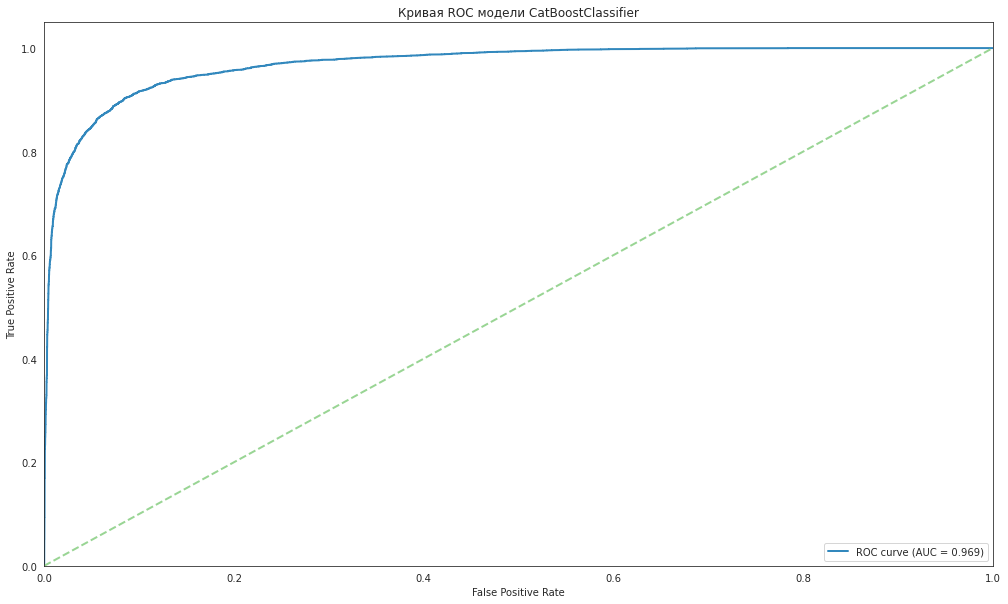

0.968506389731782

In [41]:
plot_roc_curve(y_train, catboost_proba_train)

In [42]:
get_reports(catboost_proba_train, y_train)

ROC AUC: 0.969


,top 1%,top 3%,top 5%,top 10%,top 15%,top 20%,top 30%,top 40%,top 50%,top 60%,top 70%,top 80%,top 90%,top 100%
LIFT,3.313,3.307,3.313,3.281,3.271,3.238,2.885,2.370,1.955,1.649,1.425,1.250,1.111,1.0
PRECISION,0.994,0.992,0.994,0.984,0.981,0.971,0.865,0.711,0.586,0.495,0.427,0.375,0.333,0.3
RECALL,0.033,0.099,0.166,0.328,0.491,0.648,0.865,0.948,0.977,0.989,0.997,1.000,1.000,1.0
COUNT,167.000,499.000,832.000,1663.000,2494.000,3326.000,4988.000,6651.000,8313.000,9976.000,11639.000,13301.000,14964.000,16626.0


## Test metrics

In [43]:
accuracy = accuracy_score(y_test, catboost_pred_test)
recall = recall_score(y_test, catboost_pred_test)
precision = precision_score(y_test, catboost_pred_test)
roc_auc = roc_auc_score(y_test, catboost_proba_test)

precision_points, recall_points, _ = precision_recall_curve(y_test, catboost_proba_test) 
prc_auc = auc(recall_points, precision_points)

print('Accuracy:', np.round(accuracy, 3))
print('Recall:', np.round(recall, 3))
print('Precision:', np.round(precision, 3))
print('ROC AUC:', np.round(roc_auc, 3))
print('PRC AUC:', np.round(prc_auc, 3))

Accuracy: 0.826
Recall: 0.553
Precision: 0.155
ROC AUC: 0.775
PRC AUC: 0.184


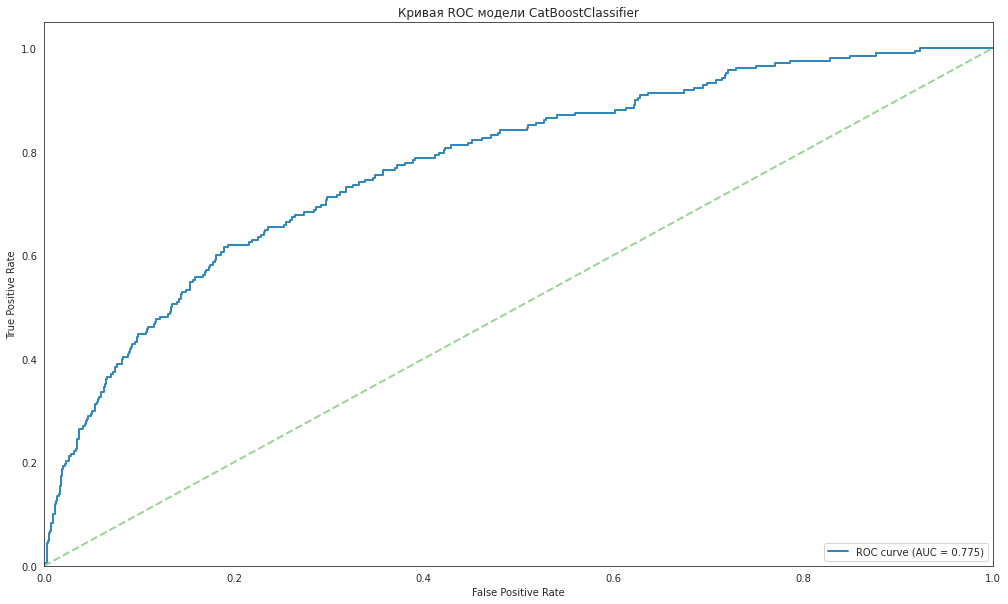

0.7753253014395075

In [44]:
plot_roc_curve(y_test, catboost_proba_test)

In [45]:
get_reports(catboost_proba_test, y_test)

ROC AUC: 0.775


,top 1%,top 3%,top 5%,top 10%,top 15%,top 20%,top 30%,top 40%,top 50%,top 60%,top 70%,top 80%,top 90%,top 100%
LIFT,7.138,6.395,5.285,4.036,3.267,2.931,2.276,1.935,1.683,1.458,1.319,1.220,1.101,1.00
PRECISION,0.357,0.320,0.264,0.202,0.163,0.147,0.114,0.097,0.084,0.073,0.066,0.061,0.055,0.05
RECALL,0.072,0.192,0.264,0.404,0.490,0.587,0.683,0.774,0.841,0.875,0.923,0.976,0.990,1.00
COUNT,42.000,125.000,208.000,416.000,624.000,832.000,1247.000,1663.000,2078.000,2494.000,2910.000,3325.000,3741.000,4156.00


## Viewing

In [48]:
y_train.sum(), catboost_pred_train.sum()

(4988, 3990)

In [49]:
y_test.sum(), catboost_pred_test.sum()

(208, 744)

In [51]:
zipped = zip(y_test, catboost_pred_test, catboost_proba_test)
list_zipped = list(zipped)

In [53]:
[x for x in list_zipped]

[(0, 1, 0.7028859148635956),
 (0, 0, 0.07222754332042611),
 (0, 0, 0.0062801263408505115),
 (0, 0, 0.07281101324322217),
 (0, 0, 0.3632668037936944),
 (0, 0, 0.3139858945500899),
 (0, 0, 0.381623607979225),
 (0, 0, 0.273073596084775),
 (0, 0, 0.4184130617033293),
 (0, 0, 0.00836805214337569),
 (0, 0, 0.14554516816957677),
 (0, 1, 0.811969265609894),
 (0, 0, 0.08326891103902809),
 (0, 1, 0.7543910162913118),
 (0, 1, 0.6456490476844686),
 (0, 0, 0.46625378496188746),
 (0, 0, 0.2667896126648166),
 (0, 0, 0.040646408638600334),
 (0, 0, 0.023561474651891925),
 (0, 0, 0.21810494232300032),
 (0, 0, 0.15005036465219157),
 (0, 0, 0.02798400377414158),
 (0, 0, 0.07155116857758295),
 (0, 0, 0.36287897902574484),
 (0, 0, 0.2197310701836675),
 (0, 0, 0.3529149073815761),
 (0, 0, 0.06741369933033686),
 (0, 1, 0.6374950060788234),
 (0, 0, 0.07266077852532792),
 (0, 0, 0.3186156227345647),
 (0, 0, 0.095078382922504),
 (0, 0, 0.4191314025453687),
 (0, 0, 0.44798270658550643),
 (0, 0, 0.0562928807877672

# SHAP

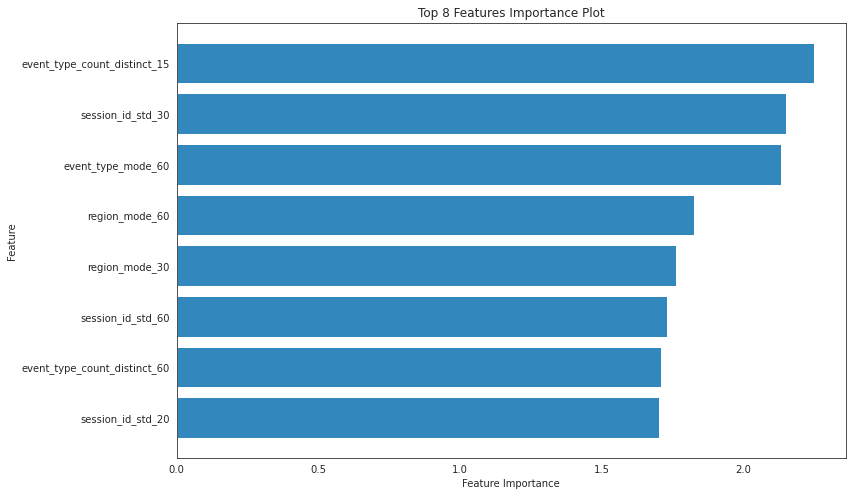

CPU times: user 197 ms, sys: 195 ms, total: 391 ms
Wall time: 173 ms


In [64]:
%%time
feature_importance = catboost.get_feature_importance()
feature_names = X_train.columns
sorted_feature_importance = sorted(zip(feature_names, feature_importance), key=lambda x: x[1], reverse=True)

top_40_features = [feature for feature, importance in sorted_feature_importance[:8]]
top_40_importance = [importance for feature, importance in sorted_feature_importance[:8]]

plt.figure(figsize=(12, 8))
plt.barh(top_40_features, top_40_importance, color=color[0]) # '#74197f','#14b956'
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top 8 Features Importance Plot')
plt.gca().invert_yaxis()  # Invert y-axis to display the most important features at the top
plt.show()

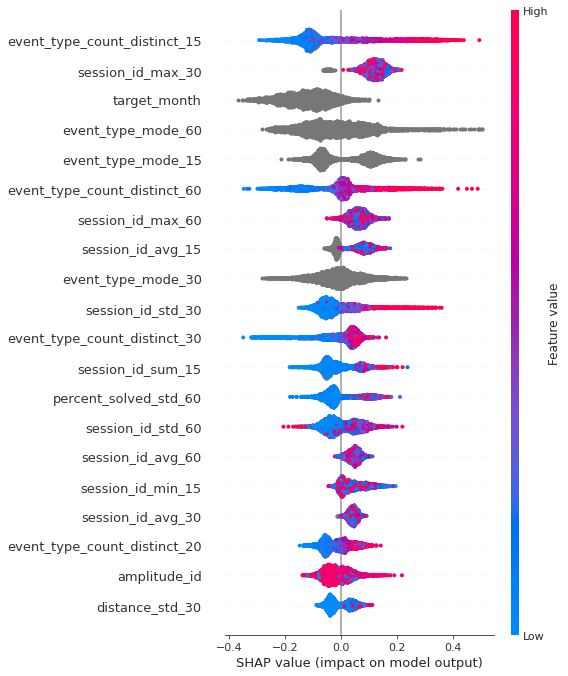

CPU times: user 6min 51s, sys: 3.74 s, total: 6min 55s
Wall time: 35.7 s


In [65]:
%%time
explainer = shap.TreeExplainer(catboost)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type='dot') # use this easier

# `XGBoost()` Model

In [1]:
X_train_encoded = pd.get_dummies(X_train)
X_test_encoded = pd.get_dummies(X_test)
X_train_encoded, X_test_encoded = X_train_encoded.align(X_test_encoded, join='left', axis=1, fill_value=0)

NameError: name 'pd' is not defined

In [60]:
X_train_encoded.shape, X_test_encoded.shape

((16627, 62376), (4157, 62376))

In [ ]:
# catboost = CatBoostClassifier(iterations = 700, 
#                               #depth = 10,
#                               #l2_leaf_reg = 7,
#                               #learning_rate = 0.05,
#                               logging_level='Silent', 
#                               cat_features = categorical_features,
#                               #use_best_model=True,
#                               early_stopping_rounds=10,
#                               #eval_metric='AUC',
#                               loss_function='CrossEntropy',
#                               random_seed = SEED)

In [61]:
params = {
    'max_depth': 10,             # Similar to CatBoost
    'learning_rate': 0.05,       # Same as CatBoost
    'subsample': 1,              # Default value in XGBoost
    'colsample_bytree': 1,       # Similar behavior as CatBoost in terms of feature sampling
    'lambda': 7,                 # L2 regularization term in XGBoost (similar to l2_leaf_reg in CatBoost)
    'objective': 'binary:logistic',  # Assuming this is a binary classification problem
    'eval_metric': 'auc',        # Evaluation metric
    'seed': SEED                 # Random seed for reproducibility
}

In [62]:
%%time
dtrain = xgb.DMatrix(X_train_encoded, label=y_train)
dtest = xgb.DMatrix(X_test_encoded, label=y_test)

evals = [(dtrain, 'train'), (dtest, 'eval')]

# evals=[(dtest, 'eval')]
bst = xgb.train(params, dtrain, num_boost_round=700,
                evals=evals, early_stopping_rounds=10,
                verbose_eval=False) 

CPU times: user 15min 26s, sys: 19.3 s, total: 15min 46s
Wall time: 2min 32s


In [63]:
%%time
xgb_proba_train = bst.predict(dtrain, iteration_range=(0, bst.best_iteration + 1)) #ntree_limit=model.best_ntree_limit)
xgb_pred_train = (xgb_proba_train >= 0.5).astype(int)

CPU times: user 3.49 s, sys: 7.95 ms, total: 3.5 s
Wall time: 338 ms


In [64]:
%%time
xgb_proba_test = bst.predict(dtest, iteration_range=(0, bst.best_iteration + 1)) #ntree_limit=model.best_ntree_limit
xgb_pred_test = (xgb_proba_test >= 0.5).astype(int)

CPU times: user 960 ms, sys: 11.2 ms, total: 971 ms
Wall time: 148 ms


In [65]:
xgb_pred_test.sum(), y_test.sum()

(560, 208)

In [66]:
X_test.target_month

495036    2023-09-01
689504    2023-09-01
541661    2023-09-01
170226    2023-08-01
721265    2023-09-01
             ...    
173990    2023-09-01
125458    2023-08-01
403360    2023-09-01
672746    2023-08-01
435502    2023-08-01
Name: target_month, Length: 4157, dtype: category
Categories (2, object): ['2023-08-01', '2023-09-01']

In [ ]:
# catboost - лучше опрелеляет общее число единиц для подвыборки, но эти единицы прогнозирует для истинных нулей
# xgbbost - попдает в истинные единицы, но из истинных недопрогнозит

In [ ]:
0.175 - 

## Train Metrics

In [40]:
accuracy = accuracy_score(y_train, xgb_pred_train)
recall = recall_score(y_train, xgb_pred_train)
precision = precision_score(y_train, xgb_pred_train)
roc_auc = roc_auc_score(y_train, xgb_proba_train)

precision_points, recall_points, _ = precision_recall_curve(y_train, xgb_proba_train) 
prc_auc = auc(recall_points, precision_points)

print('Accuracy:', np.round(accuracy, 3))
print('Recall:', np.round(recall, 3))
print('Precision:', np.round(precision, 3))
print('ROC AUC:', np.round(roc_auc, 3))
print('PRC AUC:', np.round(prc_auc, 3))

Accuracy: 0.859
Recall: 0.604
Precision: 0.892
ROC AUC: 0.939
PRC AUC: 0.878


In [64]:
# plot_roc_curve(y_train, xgb_proba_train)

In [41]:
get_reports(xgb_proba_train, y_train)

ROC AUC: 0.939


,top 1%,top 3%,top 5%,top 10%,top 15%,top 20%,top 30%,top 40%,top 50%,top 60%,top 70%,top 80%,top 90%,top 100%
LIFT,3.293,3.267,3.249,3.209,3.117,2.987,2.671,2.270,1.910,1.627,1.414,1.247,1.111,1.0
PRECISION,0.988,0.980,0.975,0.963,0.935,0.896,0.801,0.681,0.573,0.488,0.424,0.374,0.333,0.3
RECALL,0.033,0.098,0.163,0.321,0.468,0.597,0.801,0.908,0.955,0.976,0.990,0.998,1.000,1.0
COUNT,167.000,499.000,832.000,1663.000,2494.000,3326.000,4988.000,6651.000,8313.000,9976.000,11639.000,13301.000,14964.000,16624.0


## Test Metrics

In [42]:
accuracy = accuracy_score(y_test, xgb_pred_test)
recall = recall_score(y_test, xgb_pred_test)
precision = precision_score(y_test, xgb_pred_test)
roc_auc = roc_auc_score(y_test, xgb_proba_test)

precision_points, recall_points, _ = precision_recall_curve(y_test, xgb_proba_test) 
prc_auc = auc(recall_points, precision_points)

print('Accuracy:', np.round(accuracy, 3))
print('Recall:', np.round(recall, 3))
print('Precision:', np.round(precision, 3))
print('ROC AUC:', np.round(roc_auc, 3))
print('PRC AUC:', np.round(prc_auc, 3))

Accuracy: 0.86
Recall: 0.452
Precision: 0.168
ROC AUC: 0.783
PRC AUC: 0.175


In [ ]:
# plot_roc_curve(y_test, catboost_proba_test)

In [43]:
get_reports(xgb_proba_test, y_test)

ROC AUC: 0.783


,top 1%,top 3%,top 5%,top 10%,top 15%,top 20%,top 30%,top 40%,top 50%,top 60%,top 70%,top 80%,top 90%,top 100%
LIFT,5.234,5.116,4.996,3.939,3.331,2.834,2.356,1.959,1.712,1.531,1.360,1.226,1.111,1.001
PRECISION,0.262,0.256,0.250,0.197,0.167,0.142,0.118,0.098,0.086,0.077,0.068,0.061,0.056,0.050
RECALL,0.053,0.154,0.250,0.394,0.500,0.567,0.707,0.784,0.856,0.918,0.952,0.981,1.000,1.000
COUNT,42.000,125.000,208.000,416.000,624.000,832.000,1247.000,1663.000,2078.000,2494.000,2910.000,3325.000,3741.000,4153.000


# `LightGBM()` Model

In [69]:
for col in categorical_features:
    X_train[col] = X_train[col].astype('category')
    X_test[col] = X_test[col].astype('category')

In [70]:
params = {
    'boosting_type': 'gbdt',  # Using traditional Gradient Boosting Decision Tree
    'max_depth': 10,  # Corresponds to CatBoost depth
    'num_leaves': min(2**10, 2**(10+1)-1),  # LightGBM uses num_leaves, roughly 2^max_depth
    'learning_rate': 0.05,  # Same as CatBoost
    'objective': 'binary',  # Assuming binary classification, adjust accordingly
    'metric': 'auc',  # Evaluation metric
    'lambda_l2': 7,  # Equivalent to l2_leaf_reg in CatBoost
    'verbosity': -1,  # Equivalent to Silent mode in CatBoost
    'random_state': SEED,  # Ensuring reproducibility
    'early_stopping_round': 10,  # Early stopping rounds
    'is_unbalance': True  # If data is unbalanced, similar to scale_pos_weight in CatBoost
}

In [71]:
train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_features)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

In [72]:
evals_result = {}
gbm = lgb.train(params,
                train_data,
                num_boost_round=700,
                valid_sets=[test_data],
                valid_names=['eval'])
                #evals_result=evals_result,
                #early_stopping_rounds=10)

In [73]:
%%time
lgb_proba_train = gbm.predict(X_train, num_iteration=gbm.best_iteration)
lgb_pred_train = (lgb_proba_train >= 0.5).astype(int)

CPU times: user 1.17 s, sys: 24.1 ms, total: 1.2 s
Wall time: 87.2 ms


In [74]:
%%time
lgb_proba_test = gbm.predict(X_test, num_iteration=gbm.best_iteration)
lgb_pred_test = (lgb_proba_test >= 0.5).astype(int)

CPU times: user 932 ms, sys: 24 ms, total: 956 ms
Wall time: 60 ms


In [75]:
lgb_pred_test.sum(), y_test.sum()

(1132, 208)

## Train Metrics

In [55]:
accuracy = accuracy_score(y_train, lgb_pred_train)
recall = recall_score(y_train, lgb_pred_train)
precision = precision_score(y_train, lgb_pred_train)
roc_auc = roc_auc_score(y_train, lgb_proba_train)

precision_points, recall_points, _ = precision_recall_curve(y_train, lgb_proba_train) 
prc_auc = auc(recall_points, precision_points)

print('Accuracy:', np.round(accuracy, 3))
print('Recall:', np.round(recall, 3))
print('Precision:', np.round(precision, 3))
print('ROC AUC:', np.round(roc_auc, 3))
print('PRC AUC:', np.round(prc_auc, 3))

Accuracy: 0.881
Recall: 0.909
Precision: 0.748
ROC AUC: 0.95
PRC AUC: 0.87


In [ ]:
# plot_roc_curve(y_train, lgb_proba_train)

In [56]:
get_reports(lgb_proba_train, y_train)

ROC AUC: 0.950


,top 1%,top 3%,top 5%,top 10%,top 15%,top 20%,top 30%,top 40%,top 50%,top 60%,top 70%,top 80%,top 90%,top 100%
LIFT,3.154,3.153,3.173,3.131,3.006,2.915,2.695,2.356,1.970,1.658,1.425,1.250,1.111,1.0
PRECISION,0.946,0.946,0.952,0.939,0.902,0.875,0.808,0.707,0.591,0.497,0.428,0.375,0.333,0.3
RECALL,0.032,0.095,0.159,0.313,0.451,0.583,0.808,0.942,0.985,0.995,0.998,1.000,1.000,1.0
COUNT,167.000,499.000,832.000,1663.000,2494.000,3326.000,4988.000,6651.000,8313.000,9976.000,11639.000,13301.000,14964.000,16626.0


## Test Metrics

In [57]:
accuracy = accuracy_score(y_test, lgb_pred_test)
recall = recall_score(y_test, lgb_pred_test)
precision = precision_score(y_test, lgb_pred_test)
roc_auc = roc_auc_score(y_test, lgb_proba_test)

precision_points, recall_points, _ = precision_recall_curve(y_test, lgb_proba_test) 
prc_auc = auc(recall_points, precision_points)

print('Accuracy:', np.round(accuracy, 3))
print('Recall:', np.round(recall, 3))
print('Precision:', np.round(precision, 3))
print('ROC AUC:', np.round(roc_auc, 3))
print('PRC AUC:', np.round(prc_auc, 3))

Accuracy: 0.729
Recall: 0.683
Precision: 0.118
ROC AUC: 0.784
PRC AUC: 0.171


In [ ]:
# plot_roc_curve(y_test, lgb_proba_test)

In [58]:
get_reports(lgb_proba_test, y_test)

ROC AUC: 0.784


,top 1%,top 3%,top 5%,top 10%,top 15%,top 20%,top 30%,top 40%,top 50%,top 60%,top 70%,top 80%,top 90%,top 100%
LIFT,4.283,5.116,5.189,4.084,3.331,2.810,2.308,2.007,1.683,1.539,1.380,1.220,1.095,1.00
PRECISION,0.214,0.256,0.260,0.204,0.167,0.141,0.115,0.100,0.084,0.077,0.069,0.061,0.055,0.05
RECALL,0.043,0.154,0.260,0.409,0.500,0.562,0.692,0.803,0.841,0.923,0.966,0.976,0.986,1.00
COUNT,42.000,125.000,208.000,416.000,624.000,832.000,1247.000,1663.000,2078.000,2494.000,2910.000,3325.000,3741.000,4156.00


In [18]:
important_vars_xgb = pickle.load(open(r'/data/svarygin/yt_change_device/pickles/important_vars.pickle.dat','rb'))
catboost = pickle.load(open(r'/data/svarygin/yt_change_device/pickles/final_model_binary.pickle.dat','rb'))

# Feature selection

In [19]:
%%time
# алгоритм отбора
selector = RandomForestClassifier(min_samples_leaf=300, n_estimators=500, max_depth=4, random_state=17, n_jobs=60)

# алгоритм оценки качества
clf = XGBClassifier(**{'colsample_bytree': 1.0,
         'learning_rate': 0.15,
         'max_depth': 3,
         'min_child_weight': 100,
         'n_estimators': 100,
         'subsample': 0.55,
         'n_jobs': 60})

important_vars = feature_selection(
    selector, 
    X_train[numerical_features], 
    y_train, 
    X_test[numerical_features], 
    y_test, 
    model=clf, 
    n_steps=5, 
    threshold=0.005
)

[00:22:45] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:28:23] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2023-09-21 00:33:27,070 INFO ALL. roc_auc_score: [0.67481, 0.66807],
                number: 488
2023-09-21 00:33:27,074 INFO SELECTED. roc_auc_score: [0.6746, 0.66844],
                 number: 340


[00:33:47] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:39:23] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2023-09-21 00:44:19,749 INFO ALL. roc_auc_score: [0.67481, 0.66807],
                number: 488
2023-09-21 00:44:19,753 INFO SELECTED. roc_auc_score: [0.67443, 0.66839],
                 number: 306


[00:44:40] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:50:21] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2023-09-21 00:54:54,089 INFO ALL. roc_auc_score: [0.67481, 0.66807],
                number: 488
2023-09-21 00:54:54,096 INFO SELECTED. roc_auc_score: [0.67424, 0.66774],
                 number: 272


[00:55:14] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:00:44] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2023-09-21 01:04:57,834 INFO ALL. roc_auc_score: [0.67481, 0.66807],
                number: 488
2023-09-21 01:04:57,838 INFO SELECTED. roc_auc_score: [0.67367, 0.6674],
                 number: 238


[01:05:19] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:10:49] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2023-09-21 01:14:40,511 INFO ALL. roc_auc_score: [0.67481, 0.66807],
                number: 488
2023-09-21 01:14:40,514 INFO SELECTED. roc_auc_score: [0.67307, 0.66635],
                 number: 204


[01:14:58] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:20:30] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2023-09-21 01:24:06,054 INFO ALL. roc_auc_score: [0.67481, 0.66807],
                number: 488
2023-09-21 01:24:06,057 INFO SELECTED. roc_auc_score: [0.67205, 0.66541],
                 number: 170
2023-09-21 01:24:06,059 INFO Final: 170 variables


In [10]:
pickle.dump(important_vars_xgb, open(r'/data/svarygin/yt_change_device/pickles/important_vars.pickle.dat','wb'))